## Importing Libraries

In [1]:
from pyomo.environ import *
from pyomo.environ import value, sin, asin, cos, acos
from pyomo.environ import SolverFactory, TerminationCondition
from pyomo.environ import Objective, maximize, minimize
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime, timedelta
import math
import random
import pvlib
os.chdir('C:\\Users\\Lenovo\\OneDrive - Ashesi University\\Desktop\\Master Thesis')

In [2]:
test_file = pd.read_excel('Energy_prod_data/Full_One_Year_Irradiance_Data.xlsx', engine='openpyxl')
test_file.head(3)

,Datetime,Hour,GHI,DNI,DHI,KT,Temp,WS10M
0,2023-05-01 01:00:00,01:00:00,0.0,0.0,0.0,-999.0,26.8,3.49
1,2023-05-01 02:00:00,02:00:00,0.0,0.0,0.0,-999.0,26.6,3.52
2,2023-05-01 03:00:00,03:00:00,0.0,0.0,0.0,-999.0,26.3,3.38


## Defining Optimization Model

In [3]:
model = ConcreteModel()

# Define the index set using the IDs from the data
model.I = Set(initialize = test_file.index)

PI = 3.141592653589793

In [4]:
Average_Load_Profile = pd.read_excel('Energy_prod_data/Ashesi_One_Year_Hourly_LoadProfile.xlsx', engine='openpyxl')
#Average_Load_Profile = pd.read_excel('Data/Final_LoadProfile.xlsx', engine='openpyxl')

# Power = list(Average_Load_Profile['Average Hourly Power Consumption']) 
# Yearly_Power_Demand = {index: Power[index % 24] for index in range(24 * 366)}
# model.AverageYearly_PowerDemand = Param(model.I, initialize=Yearly_Power_Demand, within=NonNegativeReals)

model.AverageYearly_PowerDemand = Param(model.I, initialize = (Average_Load_Profile['Hourly Power Demand kw']).to_dict(), within=NonNegativeReals)

## Loading Data and Estimating Irradiance Parameters

In [5]:
model.n_day = Param(model.I, initialize = (test_file['Datetime'].dt.dayofyear).to_dict(), within=NonNegativeReals)
model.time_hours = Param(model.I, initialize = (test_file['Datetime'].dt.hour).to_dict(), within=NonNegativeReals)
model.GHI_array = Param(model.I, initialize = (test_file['GHI']).to_dict(), within=NonNegativeReals)
model.Ambient_Temperature_array = Param(model.I, initialize = (test_file['Temp']).to_dict(), within=NonNegativeReals)
model.Wind_Speed_array = Param(model.I, initialize = (test_file['WS10M']).to_dict(), within=NonNegativeReals)

In [6]:

model.lat = Param(initialize = math.radians(5.7603))

model.B = Param(model.I, initialize = {i: math.radians((model.n_day[i]-1)*(360/365)) for i in model.I}, mutable=True)
model.EoT = Param(model.I, initialize = {i: 229.2*(0.000075+(0.001868*cos(model.B[i]))-(0.032077*sin(model.B[i]))-\
                                          (0.014615*cos(2*model.B[i]))-(0.04089*sin(2*model.B[i]))) for i in model.I}, mutable=True)


model.ST = Param(model.I, initialize = {i: model.time_hours[i] + ((4*(0-0.2199)+model.EoT[i])/60) for i in model.I}, mutable = True)

model.hour_angle = Param(model.I, initialize = {i: math.radians(15*(12 - value(model.ST[i]))) for i in model.I}, mutable=True)

model.dec = Param(model.I, initialize = {i: math.radians(23.45*(sin(math.radians(360*((284 + model.n_day[i])/365))))) for i in model.I}, mutable=True)


model.zenith_angle = Param(model.I, initialize = {i: (acos((cos(model.lat)*cos(model.dec[i])*cos(model.hour_angle[i])) + (sin(model.lat)*sin(model.dec[i])))*0.9) for i in model.I}, mutable=True)
model.elevation_angle = Param(model.I, initialize = {i: (asin((cos(model.lat)*cos(model.dec[i])*cos(model.hour_angle[i])) + (sin(model.lat)*sin(model.dec[i])))*0.9) for i in model.I}, mutable=True)
model.solar_azimuth = Param(model.I, initialize = {i: acos((-cos(model.dec[i])*sin(model.hour_angle[i]))/cos(model.elevation_angle[i])) for i in model.I}, mutable=True)



model.Gext = Param(model.I, initialize = {i: 1367*(1+(0.033*cos(math.radians((360*model.n_day[i])/365)))) for i in model.I}, within=NonNegativeReals, mutable=True)
model.Kt = Param(model.I, initialize = {i: model.GHI_array[i]/model.Gext[i] for i in model.I}, within=NonNegativeReals, mutable=True)

In [7]:
mu = 10.9 
sigma = 3

Fd_values = {}
DHI_values = {}
DNI_values = {}

for i in model.I:
    kt_value = value(model.Kt[i])
    ghi_value = value(model.GHI_array[i])
    zenith = value(model.zenith_angle[i])
    
    if kt_value < 0.22:
        Fd_values[i] = 1 - (0.09 * kt_value)
    elif 0.22 < kt_value <= 0.8:
        Fd_values[i] = 0.9511 - (0.1604 * kt_value) + (4.388 * kt_value**2) - (16.638 * kt_value**3) + (12.336 * kt_value**4)
    elif kt_value > 0.8:
        Fd_values[i] = 0.165
    
    DHI_values[i] = Fd_values[i] * ghi_value
    DNI_values[i] = (ghi_value - DHI_values[i]) / cos(zenith)


model.Fd = Param(model.I, initialize=Fd_values, within=NonNegativeReals)
model.DHI = Param(model.I, initialize=DHI_values, within=NonNegativeReals)
model.DNI = Param(model.I, initialize=DNI_values, within=NonNegativeReals)


model.P_gaussian_const = Param(model.I, initialize = {i: value(model.Kt[i]) * math.exp(-(model.time_hours[i] - mu)**2 / (2 * sigma**2)) for i in model.I}, within=NonNegativeReals, mutable=True)

## Existing Installation

In [8]:
existing_PV_Installation_azimuth_degrees = [253.57, 75.22, 294.17, 111.85, 343, 159.21, 26]  ### azimuth angles -154
existing_PV_azimuth = [math.radians(angle) for angle in existing_PV_Installation_azimuth_degrees]
model.K = RangeSet(0, len(existing_PV_azimuth) - 1)

existing_PV_Azimuth = {index: value for index, value in enumerate(existing_PV_azimuth)}
model.Existing_PV_Azimuth_Angles = Param(model.K, initialize=existing_PV_Azimuth)

In [9]:
model.tiltAngle_Existing_PV_Engineering = Param(model.K, initialize=14*PI/180)
model.tiltAngle_Existing_PV_Library = Param(model.K, initialize=13*PI/180)
model.tiltAngle_Existing_PV_Founders = Param(model.K, initialize=20*PI/180)


    

model.Existing_PV_panelRating = Param(initialize=270)  ### 270 watts
model.Existing_PV_totalNum_panels = Param(initialize=718)
model.Existing_PV_capacity = Param(initialize = model.Existing_PV_totalNum_panels * model.Existing_PV_panelRating)

Existing_PVpanels_Num_corres_toAzimuth_Engineering = [25, 32, 60, 81, 12, 28, 0]
Existing_PVpanels_Engineering = {index: value for index, value in enumerate(Existing_PVpanels_Num_corres_toAzimuth_Engineering)}
model.Existing_PVpanels_Num_Engineering = Param(model.K, initialize=Existing_PVpanels_Engineering, within=NonNegativeReals)

Existing_PVpanels_Num_corres_toAzimuth_Library = [40, 40, 40, 0, 40, 40, 40]
Existing_PVpanels_Library = {index: value for index, value in enumerate(Existing_PVpanels_Num_corres_toAzimuth_Library)}
model.Existing_PVpanels_Num_Library = Param(model.K, initialize=Existing_PVpanels_Library, within=NonNegativeReals)

Existing_PVpanels_Num_corres_toAzimuth_Founders = [0, 0, 80, 100, 0, 0, 60]
Existing_PVpanels_Founders = {index: value for index, value in enumerate(Existing_PVpanels_Num_corres_toAzimuth_Founders)}
model.Existing_PVpanels_Num_Founders = Param(model.K, initialize=Existing_PVpanels_Founders, within=NonNegativeReals)

In [10]:
model.Existng_PV_Param_a = Param(initialize = -2.71)
model.Existing_PV_Param_b = Param(initialize = -0.04)
model.Existing_PV_delta_T = Param(initialize = 5)

## POA Irradiance for Existing PV Installation

In [11]:
# model.POA_Irradiance_factor_Engineering = Param(model.I, model.K, initialize = {(i, k): value(model.P_gaussian_const[i]) * value((model.DNI[i] *
#                     cos(acos((sin(model.dec[i])*sin(model.lat)*cos(model.tiltAngle_Existing_PV_Engineering[k])) -
#                     (sin(model.dec[i])*cos(model.lat)*sin(model.tiltAngle_Existing_PV_Engineering[k]) * cos(model.Existing_PV_Azimuth_Angles[k])) +
#                     (cos(model.dec[i])*cos(model.lat)*cos(model.tiltAngle_Existing_PV_Engineering[k]) * cos(model.hour_angle[i])) +
#                     (cos(model.dec[i])*sin(model.lat)*sin(model.tiltAngle_Existing_PV_Engineering[k]) * cos(model.Existing_PV_Azimuth_Angles[k]) * cos(model.hour_angle[i])) +
#                     (cos(model.dec[i])*sin(model.tiltAngle_Existing_PV_Engineering[k]) * sin(model.Existing_PV_Azimuth_Angles[k]) * sin(model.hour_angle[i]))))) + 
#                      model.DHI[i]) for i in model.I for k in model.K}, mutable=True)


model.POA_Irradiance_factor_Engineering = Param(model.I, model.K, initialize = {(i, k): value(model.P_gaussian_const[i]) * value((model.DNI[i] *
                    cos(acos((cos(model.tiltAngle_Existing_PV_Engineering[k]) * cos(model.zenith_angle[i])) +
                    (sin(model.tiltAngle_Existing_PV_Engineering[k]) * sin(model.zenith_angle[i]) * cos(model.solar_azimuth[i] - model.Existing_PV_Azimuth_Angles[k]))))) + 
                     model.DHI[i]) for i in model.I for k in model.K}, mutable=True)






# model.POA_Irradiance_factor_Library = Param(model.I, model.K, initialize = {(i, k): value(model.P_gaussian_const[i]) * value((model.DNI[i] * 
#                     cos(acos((sin(model.dec[i])*sin(model.lat)*cos(model.tiltAngle_Existing_PV_Library[k])) -
#                     (sin(model.dec[i])*cos(model.lat)*sin(model.tiltAngle_Existing_PV_Library[k]) * cos(model.Existing_PV_Azimuth_Angles[k])) +
#                     (cos(model.dec[i])*cos(model.lat)*cos(model.tiltAngle_Existing_PV_Library[k]) * cos(model.hour_angle[i])) +
#                     (cos(model.dec[i])*sin(model.lat)*sin(model.tiltAngle_Existing_PV_Library[k]) * cos(model.Existing_PV_Azimuth_Angles[k]) * cos(model.hour_angle[i])) +
#                     (cos(model.dec[i])*sin(model.tiltAngle_Existing_PV_Library[k]) * sin(model.Existing_PV_Azimuth_Angles[k]) * sin(model.hour_angle[i]))))) + 
#                      model.DHI[i]) for i in model.I for k in model.K}, mutable=True)


model.POA_Irradiance_factor_Library = Param(model.I, model.K, initialize = {(i, k): value(model.P_gaussian_const[i]) * value((model.DNI[i] *
                    cos(acos((cos(model.tiltAngle_Existing_PV_Library[k]) * cos(model.zenith_angle[i])) +
                    (sin(model.tiltAngle_Existing_PV_Library[k]) * sin(model.zenith_angle[i]) * cos(model.solar_azimuth[i] - model.Existing_PV_Azimuth_Angles[k]))))) + 
                     model.DHI[i]) for i in model.I for k in model.K}, mutable=True)





# model.POA_Irradiance_factor_Founders = Param(model.I, model.K, initialize = {(i, k): value(model.P_gaussian_const[i]) * value((model.DNI[i] * 
#                     cos(acos((sin(model.dec[i])*sin(model.lat)*cos(model.tiltAngle_Existing_PV_Founders[k])) -
#                     (sin(model.dec[i])*cos(model.lat)*sin(model.tiltAngle_Existing_PV_Founders[k]) * cos(model.Existing_PV_Azimuth_Angles[k])) +
#                     (cos(model.dec[i])*cos(model.lat)*cos(model.tiltAngle_Existing_PV_Founders[k]) * cos(model.hour_angle[i])) +
#                     (cos(model.dec[i])*sin(model.lat)*sin(model.tiltAngle_Existing_PV_Founders[k]) * cos(model.Existing_PV_Azimuth_Angles[k]) * cos(model.hour_angle[i])) +
#                     (cos(model.dec[i])*sin(model.tiltAngle_Existing_PV_Founders[k]) * sin(model.Existing_PV_Azimuth_Angles[k]) * sin(model.hour_angle[i]))))) + 
#                      model.DHI[i]) for i in model.I for k in model.K}, mutable=True)


model.POA_Irradiance_factor_Founders = Param(model.I, model.K, initialize = {(i, k): value(model.P_gaussian_const[i]) * value((model.DNI[i] *
                    cos(acos((cos(model.tiltAngle_Existing_PV_Founders[k]) * cos(model.zenith_angle[i])) +
                    (sin(model.tiltAngle_Existing_PV_Founders[k]) * sin(model.zenith_angle[i]) * cos(model.solar_azimuth[i] - model.Existing_PV_Azimuth_Angles[k]))))) + 
                     model.DHI[i]) for i in model.I for k in model.K}, mutable=True)

In [12]:

model.Cell_Temp_Engineering = Param(model.I, model.K, initialize={(i, k): ((model.Ambient_Temperature_array[i] + (value(model.POA_Irradiance_factor_Engineering[i, k]) * exp(value(model.Existng_PV_Param_a) + 
                            (value(model.Existing_PV_Param_b) * model.Wind_Speed_array[i])))) + ((value(model.POA_Irradiance_factor_Engineering[i, k]) / 1000) * value(model.Existing_PV_delta_T))) 
                             for i in model.I for k in model.K}, mutable = True)
    
    
    
    
model.Cell_Temp_Library = Param(model.I, model.K, initialize = {(i, k): ((model.Ambient_Temperature_array[i] + (value(model.POA_Irradiance_factor_Library[i, k]) * exp(value(model.Existng_PV_Param_a) + 
                            (value(model.Existing_PV_Param_b) * model.Wind_Speed_array[i])))) + ((value(model.POA_Irradiance_factor_Library[i, k]) / 1000) * value(model.Existing_PV_delta_T))) 
                             for i in model.I for k in model.K}, mutable = True)
    


    
model.Cell_Temp_Founders = Param(model.I, model.K, initialize = {(i, k): ((model.Ambient_Temperature_array[i] + (value(model.POA_Irradiance_factor_Founders[i, k]) * exp(value(model.Existng_PV_Param_a) + 
                            (value(model.Existing_PV_Param_b) * model.Wind_Speed_array[i])))) + ((value(model.POA_Irradiance_factor_Founders[i, k]) / 1000) * value(model.Existing_PV_delta_T))) 
                             for i in model.I for k in model.K}, mutable = True)

In [13]:
Existing_PV_DC_Power_values_Engineering = {}
Existing_PV_DC_Power_values_Library = {}
Existing_PV_DC_Power_values_Founders = {}
model.Existing_PV_Power_Temp_coeff = Param(initialize = -0.0041)
model.Current_degradation_rate = 0.8


for i in model.I:
    for k in model.K:
        Existing_PV_DC_Power_values_Engineering[i, k] = model.Current_degradation_rate*(((value(model.POA_Irradiance_factor_Engineering[i, k])/1000) * model.Existing_PVpanels_Num_Engineering[k] * model.Existing_PV_panelRating/1000)) * (1 + (model.Existing_PV_Power_Temp_coeff*(model.Cell_Temp_Engineering[i, k] - 25)))
        
        
        
        Existing_PV_DC_Power_values_Library[i, k] = model.Current_degradation_rate*(((value(model.POA_Irradiance_factor_Library[i, k])/1000) * model.Existing_PVpanels_Num_Library[k] * model.Existing_PV_panelRating/1000)) * (1 + (model.Existing_PV_Power_Temp_coeff*(model.Cell_Temp_Library[i, k] - 25)))
        
        
        
        Existing_PV_DC_Power_values_Founders[i, k] = model.Current_degradation_rate*(((value(model.POA_Irradiance_factor_Founders[i, k])/1000) * model.Existing_PVpanels_Num_Founders[k] * model.Existing_PV_panelRating/1000)) * (1 + (model.Existing_PV_Power_Temp_coeff*(model.Cell_Temp_Founders[i, k] - 25)))




model.Existing_PV_DC_Power_Engineering = Param(model.I, model.K, initialize = Existing_PV_DC_Power_values_Engineering, within=NonNegativeReals, mutable = True)
model.Existing_PV_DC_Power_Library = Param(model.I, model.K, initialize = Existing_PV_DC_Power_values_Library, within=NonNegativeReals, mutable = True)
model.Existing_PV_DC_Power_Founders = Param(model.I, model.K, initialize = Existing_PV_DC_Power_values_Founders, within=NonNegativeReals, mutable = True)

In [14]:
model.Existing_PV_total_DC_power = sum(sum(model.Existing_PV_DC_Power_Engineering[i, k] + model.Existing_PV_DC_Power_Library[i, k] + model.Existing_PV_DC_Power_Founders[i, k] for k in model.K) for i in model.I)

print(f'Current Total DC Power from Existing PV Installation: {value(model.Existing_PV_total_DC_power)}')
print('')

print(f'Total DC Power Production from PV @ Engineering Section: {value(sum(sum(model.Existing_PV_DC_Power_Engineering[i, k] for k in model.K)for i in model.I))}')
print(f'Total DC Power Production from PV @ Library Section: {value(sum(sum(model.Existing_PV_DC_Power_Library[i, k] for k in model.K)for i in model.I))}')
print(f'Total DC Power Production from PV @ Founders Section: {value(sum(sum(model.Existing_PV_DC_Power_Founders[i, k] for k in model.K)for i in model.I))}')

Current Total DC Power from Existing PV Installation: 245908.4512044818

Total DC Power Production from PV @ Engineering Section: 82504.31852699365
Total DC Power Production from PV @ Library Section: 82017.14455004163
Total DC Power Production from PV @ Founders Section: 81386.98812744644


In [15]:
Pdco = 75/0.98

Existing_PV_AC_Power_values_Engineering = {}
Existing_PV_AC_Power_values_Library = {}
Existing_PV_AC_Power_values_Founders = {}

for i in model.I:
    for k in model.K:
        Existing_PV_AC_Power_values_Engineering[i, k] = pvlib.inverter.pvwatts(value(model.Existing_PV_DC_Power_Engineering[i, k]), Pdco)
        Existing_PV_AC_Power_values_Library[i, k] = pvlib.inverter.pvwatts(value(model.Existing_PV_DC_Power_Library[i, k]), Pdco)
        Existing_PV_AC_Power_values_Founders[i, k] = pvlib.inverter.pvwatts(value(model.Existing_PV_DC_Power_Founders[i, k]), Pdco)



model.Existing_PV_AC_Power_Engineering = Param(model.I, model.K, initialize = Existing_PV_AC_Power_values_Engineering, within = NonNegativeReals, mutable = True)
model.Existing_PV_AC_Power_Library = Param(model.I, model.K, initialize = Existing_PV_AC_Power_values_Library, within = NonNegativeReals, mutable = True)
model.Existing_PV_AC_Power_Founders = Param(model.I, model.K, initialize = Existing_PV_AC_Power_values_Founders, within = NonNegativeReals, mutable = True)

In [16]:
model.Existing_PV_total_AC_power = sum(sum(model.Existing_PV_AC_Power_Engineering[i, k] + model.Existing_PV_AC_Power_Library[i, k] + model.Existing_PV_AC_Power_Founders[i, k] for k in model.K) for i in model.I)

print(f'Current Total AC Power from Existing PV Installation: {value(model.Existing_PV_total_AC_power)}')
print('')

print(f'Total AC Power Production from PV @ Engineering Section: {value(sum(sum(model.Existing_PV_AC_Power_Engineering[i, k] for k in model.K)for i in model.I))}')
print(f'Total AC Power Production from PV @ Library Section: {value(sum(sum(model.Existing_PV_AC_Power_Library[i, k] for k in model.K)for i in model.I))}')
print(f'Total AC Power Production from PV @ Founders Section: {value(sum(sum(model.Existing_PV_AC_Power_Founders[i, k] for k in model.K)for i in model.I))}')
print('')


Current_yearly_load_Demand = np.sum(Average_Load_Profile['Hourly Power Demand kw'])
#Current_yearly_load_Demand = value(sum(model.AverageYearly_PowerDemand[i] for i in model.I))
Percent_fulfilled_by_Existing_PV_Installation = value(model.Existing_PV_total_AC_power)/Current_yearly_load_Demand

print(f'Current Fraction of Yearly Demand Fulfilled By Existing PV Installation: {round(Percent_fulfilled_by_Existing_PV_Installation * 100, 2)}')

Current Total AC Power from Existing PV Installation: 216592.08356522027

Total AC Power Production from PV @ Engineering Section: 71343.56377404662
Total AC Power Production from PV @ Library Section: 70625.03192057168
Total AC Power Production from PV @ Founders Section: 74623.48787060201

Current Fraction of Yearly Demand Fulfilled By Existing PV Installation: 11.78


### Defining Model Parameters and Variables for Future PV Installation

In [17]:
model.futurePV_azimuthAngle_East = Param(initialize = 90*PI/180)
model.futurePV_azimuthAngle_SouthEast = Param(initialize = 112*PI/180)
model.futurePV_azimuthAngle_South = Param(initialize = 183*PI/180)
model.futurePV_azimuthAngle_SouthWest =  Param(initialize = 202*PI/180)


model.tiltAngle = Param(within=NonNegativeReals, initialize=15*PI/180)


model.futurePV_panelRating = Param(within=NonNegativeReals, initialize = 450)
model.futurePV_capacity = Var(within=NonNegativeReals)  # kwp


model.epsilonEast = Var(within = NonNegativeReals, bounds = (0, 450), initialize = 0)
model.epsilonSouthEast = Var(within = NonNegativeReals, bounds = (0, 400), initialize = 0)
model.epsilonSouth = Var(within = NonNegativeReals, bounds = (0, 450), initialize = 0)
model.epsilonSouthWest = Var(within = NonNegativeReals, bounds = (0, 550), initialize = 0)


model.availableArea_East = Expression(expr = 600 + model.epsilonEast)
model.availableArea_SouthEast = Expression(expr = 800 + model.epsilonSouthEast)
model.availableArea_South = Expression(expr = 850 + model.epsilonSouth)
model.availableArea_SouthWest = Expression(expr = 700 + model.epsilonSouthWest)
model.area_per_panel = Param(within=NonNegativeReals, initialize = 2)



model.futurePV_panelNum_East =  Var(within=NonNegativeReals)
model.futurePV_panelNum_SouthEast = Var(within=NonNegativeReals)
model.futurePV_panelNum_South =  Var(within=NonNegativeReals)
model.futurePV_panelNum_SouthWest =  Var(within=NonNegativeReals)



model.futurePV_panelNum_East_constraint = Constraint(expr = model.futurePV_panelNum_East <= (model.availableArea_East/model.area_per_panel))
model.futurePV_panelNum_SouthEast_constraint = Constraint(expr = model.futurePV_panelNum_SouthEast <= (model.availableArea_SouthEast/model.area_per_panel))
model.futurePV_panelNum_South_constraint = Constraint(expr = model.futurePV_panelNum_South <= (model.availableArea_South/model.area_per_panel))
model.futurePV_panelNum_SouthWest_constraint = Constraint(expr = model.futurePV_panelNum_SouthWest <= (model.availableArea_SouthWest/model.area_per_panel))



model.panel_Efficiency = Param(initialize = 0.22, within=NonNegativeReals)




model.futurePV_capacity_constraint = Constraint(expr = model.futurePV_capacity == (model.futurePV_panelNum_East + model.futurePV_panelNum_SouthEast + model.futurePV_panelNum_South + model.futurePV_panelNum_SouthWest) * model.futurePV_panelRating/1000)

## Estimating Cell Temperature

In [18]:
# model.POA_Irradiance_factor_East = Param(model.I, initialize = {i: value(model.P_gaussian_const[i]) * value((model.DNI[i] * cos(acos((sin(model.dec[i])*sin(model.lat)*cos(model.tiltAngle)) -
#                     (sin(model.dec[i])*cos(model.lat)*sin(model.tiltAngle) * cos(model.futurePV_azimuthAngle_East)) +
#                     (cos(model.dec[i])*cos(model.lat)*cos(model.tiltAngle) * cos(model.hour_angle[i])) +
#                     (cos(model.dec[i])*sin(model.lat)*sin(model.tiltAngle) * cos(model.futurePV_azimuthAngle_East) * cos(model.hour_angle[i])) +
#                     (cos(model.dec[i])*sin(model.tiltAngle) * sin(model.futurePV_azimuthAngle_East) * sin(model.hour_angle[i]))))) + 
#                      model.DHI[i]) for i in model.I}, mutable=True)


model.POA_Irradiance_factor_East = Param(model.I, initialize = {i: value(model.P_gaussian_const[i]) * value((model.DNI[i] * cos(acos((cos(model.tiltAngle)*cos(model.zenith_angle[i])) +
                    (sin(model.tiltAngle) * sin(model.zenith_angle[i]) * cos(model.solar_azimuth[i] - model.futurePV_azimuthAngle_East)) ))) + model.DHI[i]) for i in model.I}, mutable=True)




# model.POA_Irradiance_factor_SouthEast = Param(model.I, initialize = {i: value(model.P_gaussian_const[i]) * value((model.DNI[i] * cos(acos((sin(model.dec[i])*sin(model.lat)*cos(model.tiltAngle)) -
#                     (sin(model.dec[i])*cos(model.lat)*sin(model.tiltAngle) * cos(model.futurePV_azimuthAngle_SouthEast)) +
#                     (cos(model.dec[i])*cos(model.lat)*cos(model.tiltAngle) * cos(model.hour_angle[i])) +
#                     (cos(model.dec[i])*sin(model.lat)*sin(model.tiltAngle) * cos(model.futurePV_azimuthAngle_SouthEast) * cos(model.hour_angle[i])) +
#                     (cos(model.dec[i])*sin(model.tiltAngle) * sin(model.futurePV_azimuthAngle_SouthEast) * sin(model.hour_angle[i]))))) + 
#                      model.DHI[i]) for i in model.I}, mutable=True)


model.POA_Irradiance_factor_SouthEast = Param(model.I, initialize = {i: value(model.P_gaussian_const[i]) * value((model.DNI[i] * cos(acos((cos(model.tiltAngle)*cos(model.zenith_angle[i])) +
                    (sin(model.tiltAngle) * sin(model.zenith_angle[i]) * cos(model.solar_azimuth[i] - model.futurePV_azimuthAngle_SouthEast)) ))) + model.DHI[i]) for i in model.I}, mutable=True)




# model.POA_Irradiance_factor_South = Param(model.I, initialize = {i: value(model.P_gaussian_const[i]) * value((model.DNI[i] * cos(acos((sin(model.dec[i])*sin(model.lat)*cos(model.tiltAngle)) -
#                     (sin(model.dec[i])*cos(model.lat)*sin(model.tiltAngle) * cos(model.futurePV_azimuthAngle_South)) +
#                     (cos(model.dec[i])*cos(model.lat)*cos(model.tiltAngle) * cos(model.hour_angle[i])) +
#                     (cos(model.dec[i])*sin(model.lat)*sin(model.tiltAngle) * cos(model.futurePV_azimuthAngle_South) * cos(model.hour_angle[i])) +
#                     (cos(model.dec[i])*sin(model.tiltAngle) * sin(model.futurePV_azimuthAngle_South) * sin(model.hour_angle[i]))))) + 
#                      model.DHI[i]) for i in model.I}, mutable=True)



model.POA_Irradiance_factor_South = Param(model.I, initialize = {i: value(model.P_gaussian_const[i]) * value((model.DNI[i] * cos(acos((cos(model.tiltAngle)*cos(model.zenith_angle[i])) +
                    (sin(model.tiltAngle) * sin(model.zenith_angle[i]) * cos(model.solar_azimuth[i] - model.futurePV_azimuthAngle_South)) ))) + model.DHI[i]) for i in model.I}, mutable=True)




# model.POA_Irradiance_factor_SouthWest = Param(model.I, initialize = {i: value(model.P_gaussian_const[i]) * value((model.DNI[i] * cos(acos((sin(model.dec[i])*sin(model.lat)*cos(model.tiltAngle)) -
#                     (sin(model.dec[i])*cos(model.lat)*sin(model.tiltAngle) * cos(model.futurePV_azimuthAngle_SouthWest)) +
#                     (cos(model.dec[i])*cos(model.lat)*cos(model.tiltAngle) * cos(model.hour_angle[i])) +
#                     (cos(model.dec[i])*sin(model.lat)*sin(model.tiltAngle) * cos(model.futurePV_azimuthAngle_SouthWest) * cos(model.hour_angle[i])) +
#                     (cos(model.dec[i])*sin(model.tiltAngle) * sin(model.futurePV_azimuthAngle_SouthWest) * sin(model.hour_angle[i]))))) + 
#                      model.DHI[i]) for i in model.I}, mutable=True)



model.POA_Irradiance_factor_SouthWest = Param(model.I, initialize = {i: value(model.P_gaussian_const[i]) * value((model.DNI[i] * cos(acos((cos(model.tiltAngle)*cos(model.zenith_angle[i])) +
                    (sin(model.tiltAngle) * sin(model.zenith_angle[i]) * cos(model.solar_azimuth[i] - model.futurePV_azimuthAngle_SouthWest)) ))) + model.DHI[i]) for i in model.I}, mutable=True)

In [19]:
model.Param_a = Param(initialize = -2.71)
model.Param_b = Param(initialize = -0.04)
model.delta_T = Param(initialize = 5)



Back_Surface_Module_Temp_values_East = {}
Cell_Temp_values_East = {}


Back_Surface_Module_Temp_values_SouthEast = {}
Cell_Temp_values_SouthEast = {}


Back_Surface_Module_Temp_values_South = {}
Cell_Temp_values_South = {}


Back_Surface_Module_Temp_values_SouthWest = {}
Cell_Temp_values_SouthWest = {}


for i in model.I:
    Back_Surface_Module_Temp_values_East[i] = model.Ambient_Temperature_array[i] + (value(model.POA_Irradiance_factor_East[i]) * value(math.exp(model.Param_a + (model.Param_b * model.Wind_Speed_array[i]))))

    Back_Surface_Module_Temp_values_SouthEast[i] = model.Ambient_Temperature_array[i] + (value(model.POA_Irradiance_factor_SouthEast[i]) * value(math.exp(model.Param_a + (model.Param_b * model.Wind_Speed_array[i]))))

    Back_Surface_Module_Temp_values_South[i] = model.Ambient_Temperature_array[i] + (value(model.POA_Irradiance_factor_South[i]) * value(math.exp(model.Param_a + (model.Param_b * model.Wind_Speed_array[i]))))

    Back_Surface_Module_Temp_values_SouthWest[i] = model.Ambient_Temperature_array[i] + (value(model.POA_Irradiance_factor_SouthWest[i]) * value(math.exp(model.Param_a + (model.Param_b * model.Wind_Speed_array[i]))))
    
    Cell_Temp_values_East[i] = value(Back_Surface_Module_Temp_values_East[i]) + ((value(model.POA_Irradiance_factor_East[i]) / 1000) * model.delta_T)

    Cell_Temp_values_SouthEast[i] = value(Back_Surface_Module_Temp_values_SouthEast[i]) + ((value(model.POA_Irradiance_factor_SouthEast[i]) / 1000) * model.delta_T)
    
    Cell_Temp_values_South[i] = value(Back_Surface_Module_Temp_values_South[i]) + ((value(model.POA_Irradiance_factor_South[i]) / 1000) * model.delta_T)

    Cell_Temp_values_SouthWest[i] = value(Back_Surface_Module_Temp_values_SouthWest[i]) + ((value(model.POA_Irradiance_factor_SouthWest[i]) / 1000) * model.delta_T)




model.Cell_Temp_East = Param(model.I, initialize = Cell_Temp_values_East, within=NonNegativeReals, mutable = True)
model.Cell_Temp_SouthEast = Param(model.I, initialize = Cell_Temp_values_SouthEast, within=NonNegativeReals, mutable = True)
model.Cell_Temp_South = Param(model.I, initialize = Cell_Temp_values_South, within=NonNegativeReals, mutable = True)
model.Cell_Temp_SouthWest = Param(model.I, initialize = Cell_Temp_values_SouthWest, within=NonNegativeReals, mutable = True)

## Estimating Output Power from Calibrated Model: A function of Weather Data, Tilt Angle, Azimuth Angle and Solar Modules Parameters

In [20]:
model.New_PV_Power_East = Var(model.I, within=NonNegativeReals)
model.New_PV_Power_SouthEast = Var(model.I, within=NonNegativeReals)
model.New_PV_Power_South = Var(model.I, within=NonNegativeReals)
model.New_PV_Power_SouthWest = Var(model.I, within=NonNegativeReals)
model.Power_Temp_coefficeint = Param(initialize = -0.0041)

 


def PowerFunction_East_rule(model, i):
        return model.New_PV_Power_East[i] == (((value(model.POA_Irradiance_factor_East[i])/1000) * model.futurePV_panelNum_East * model.futurePV_panelRating/1000)) * (1 + (model.Power_Temp_coefficeint*(value(model.Cell_Temp_East[i]) - 25)))




model.power_function_east_constraint = Constraint(model.I, rule=PowerFunction_East_rule)




def PowerFunction_SouthEast_rule(model, i):
        return model.New_PV_Power_SouthEast[i] == (((value(model.POA_Irradiance_factor_SouthEast[i])/1000) * model.futurePV_panelNum_SouthEast * model.futurePV_panelRating/1000)) * (1 + (model.Power_Temp_coefficeint*(value(model.Cell_Temp_SouthEast[i]) - 25)))




model.power_function_southeast_constraint = Constraint(model.I, rule=PowerFunction_SouthEast_rule)





def PowerFunction_South_rule(model, i):
        return model.New_PV_Power_South[i] == (((value(model.POA_Irradiance_factor_South[i])/1000) * model.futurePV_panelNum_South * model.futurePV_panelRating/1000)) * (1 + (model.Power_Temp_coefficeint*(value(model.Cell_Temp_South[i]) - 25)))



model.power_function_south_constraint = Constraint(model.I, rule=PowerFunction_South_rule)





def PowerFunction_SouthWest_rule(model, i):
        return model.New_PV_Power_SouthWest[i] == (((value(model.POA_Irradiance_factor_SouthWest[i])/1000) * model.futurePV_panelNum_SouthWest * model.futurePV_panelRating/1000)) * (1 + (model.Power_Temp_coefficeint*(value(model.Cell_Temp_SouthWest[i]) - 25)))
    


model.power_function_southwest_constraint = Constraint(model.I, rule=PowerFunction_SouthWest_rule)

## Solar Photovoltaics Installation and Maintenance Cost 

In [21]:
model.costperKW_PV_panels = Param(initialize = 550, within=NonNegativeReals) # USD/KW
model.costperKW_Soft_cost_others = Param(initialize = 800, within=NonNegativeReals) #USD/KW
model.costperKW_Inverter = Param(initialize = 350, within=NonNegativeReals) #USD/KW

model.Inverter_capacity = Var(within=NonNegativeReals) # KW
model.Inverter_capacity_constraint = Constraint(expr = model.Inverter_capacity == model.futurePV_capacity * 0.8 * (1/0.95))


model.total_cost_KW_PV_System = Var(within = NonNegativeReals)
model.total_cost_KW_PV_System_constraint = Constraint(expr = model.total_cost_KW_PV_System == ((model.costperKW_PV_panels + model.costperKW_Soft_cost_others) * model.futurePV_capacity) + 
                                                     (model.costperKW_Inverter * model.Inverter_capacity))  # USD



model.annual_PV_maintenanace_cost = Var(within=NonNegativeReals)
model.annual_PV_maintenanace_cost_constraint = Constraint(expr = model.annual_PV_maintenanace_cost == 77 * model.futurePV_capacity)

## Simulating Grid Availability (Two State Markov Chain), Estimating Available Grid Power and its Associated Cost

In [22]:
# Parameters
total_time = 8784  # Total simulation time
dt = 1  # Time step
lambda_u = 0.07275  # Failure rate for state 0 to state 1
mu = 0.291  # Repair rate for state 1 to state 0

# Transition matrix
trans_rate_matrix = np.array([
    [0, lambda_u],
    [mu, 0]
])

# Total transition rates
lambda_total = np.sum(trans_rate_matrix, axis=1)

# Initialize counters
ON = 0
FAILED = 1

failure_times = []
recovery_times = []
state_history = [] 
time_history = []

# Simulation loop
time = 0
state = 0  # Initial state ON
failure_time = 0

while time < total_time:

    state_history.append(state)
    time_history.append(time)
    
    # Generate the time to the next transition
    time += -np.log(1 - np.random.rand()) / lambda_total[state]

    # Determine the next state
    cumsum_probs = np.cumsum(trans_rate_matrix[state, :] / lambda_total[state])
    state = np.where(cumsum_probs >= np.random.rand())[0][0]

    # If transitioning to a failure state
    if state == FAILED:
        failure_time = time
        failure_times.append(failure_time)

    # If transitioning to the repair state (index 0)
    else:
        repair_time = time
        recovery_times.append(repair_time)

# Simulation results

failure_times_array = np.array(failure_times)
recovery_times_array = np.array(recovery_times)


final_failure_times_array = []
final_recovery_times_array = []


failure_array_length, recovery_array_length = len(failure_times_array), len(recovery_times_array)

if failure_array_length > recovery_array_length:
    recovery_array_padding_val = failure_times_array[-1]
    final_recovery_times_array = np.pad(recovery_times_array, (0, failure_array_length - recovery_array_length), 'constant', constant_values= recovery_array_padding_val)
    final_failure_times_array = failure_times_array


ON_duration = total_time - sum(np.array(final_recovery_times_array) - np.array(final_failure_times_array))




### Grid Power and Costs

fraction_time_ON = ON_duration/total_time

num_ones = int(fraction_time_ON * total_time)
num_zeros = total_time - num_ones

availability = [1]*num_ones + [0]*num_zeros
random.shuffle(availability)

availability_dict = {i: availability[i] for i in range(total_time)}

model.is_grid_available = Param(model.I, initialize=availability_dict, within=NonNegativeReals)



# Parameters
model.transformerRating_grid = Param(initialize=3 * 500, within=NonNegativeReals)  # KVA
model.transformer_efficiency = Param(initialize = 0.85, within=NonNegativeReals)
model.grid_transformer_PowerFactor = Param(initialize=0.8, within=NonNegativeReals)




model.ideal_grid_maxPower_capacity = Param(within=NonNegativeReals, initialize = model.transformer_efficiency * model.transformerRating_grid * model.grid_transformer_PowerFactor)



model.costofKWh_grid = Param(initialize = 0.1677, within=NonNegativeReals)  # USD



model.gridPower_capacity = Var(model.I, within=NonNegativeReals)
def grid_availability_rule(model, i):
    return model.gridPower_capacity[i] <= model.is_grid_available[i] * model.ideal_grid_maxPower_capacity


model.grid_availability_constraint = Constraint(model.I, rule=grid_availability_rule)


model.daily_gridPower_without_PV = Param(model.I, initialize = {i: model.ideal_grid_maxPower_capacity * model.is_grid_available[i] for i in model.I}, mutable = True)

## Generators Power Production and Associated Cost

In [23]:
model.LHV_Diesel = Param(initialize = 10, within=NonNegativeReals) # 10 Kwh/l
model.gen_efficiency = Param(initialize = 0.35, within=NonNegativeReals)
# model.gen_Power_factor = Param(initialize = 0.8, within=NonNegativeReals)


# model.max_genPower_capacity = Param(initialize = 7 * 250 * model.gen_Power_factor * model.gen_efficiency, within=NonNegativeReals) # kw

model.genPower_capacity = Var(model.I, within=NonNegativeReals)


model.CostperLitre_Diesel = Param(initialize = 1, within=NonNegativeReals) # USD/L




model.costofKWh_gen = Param(initialize = model.CostperLitre_Diesel/(model.gen_efficiency * model.LHV_Diesel), within=NonNegativeReals)



# model.Average_gen_runtime_per_year = Param(initialize = 1800, within=NonNegativeReals)
# model.AverageCost_2x1000hrs_maintenance = Param(initialize = 7 * 600 * 2, within = NonNegativeReals)
# model.annualKWh_gen_maintenance_cost = Param(initialize = model.AverageCost_2x1000hrs_maintenance/(model.Average_gen_runtime_per_year * model.max_genPower_capacity), within=NonNegativeReals) # maintenance cost per Kw/year ($500 per each 250kva maintenance -> 2 times in a year). gens are service every 1000 hrs of operation. Gensets operate for 1800 hrs in a year for grid availability data.

model.Average_Annual_Cost_Diesel_Gen_maintenance = Param(initialize = 7 * 500 * 2, within = NonNegativeReals) # maintenance cost per Kw/year ($500 per each 250kva maintenance -> 2 times in a year)


def genPower_capacity_rule(model, i):
    return model.genPower_capacity[i] <= (1 - model.is_grid_available[i]) * model.ideal_grid_maxPower_capacity #model.max_genPower_capacity

model.genPower_capacity_constraint = Constraint(model.I, rule=genPower_capacity_rule)

## Load Balance and Constraints for Optimization Problem

In [24]:

def Load_Power_Balance_rule(model, i):
    return (model.gridPower_capacity[i] + (model.New_PV_Power_East[i] + model.New_PV_Power_SouthEast[i] + model.New_PV_Power_South[i] + model.New_PV_Power_SouthWest[i] + model.genPower_capacity[i]) 
            + sum(model.Existing_PV_AC_Power_Engineering[i, k] + model.Existing_PV_AC_Power_Library[i, k] + model.Existing_PV_AC_Power_Founders[i, k] for k in model.K) >= model.AverageYearly_PowerDemand[i])

 
model.Load_Power_Balance_constraint = Constraint(model.I, rule=Load_Power_Balance_rule)



def Load_Energy_Balance_rule(model):
    return (sum(model.gridPower_capacity[i] + model.New_PV_Power_East[i] + model.New_PV_Power_SouthEast[i] + model.New_PV_Power_South[i] + model.New_PV_Power_SouthWest[i] + model.genPower_capacity[i] for i in model.I) 
            + model.Existing_PV_total_AC_power >= sum(model.AverageYearly_PowerDemand[i] for i in model.I))

 
model.Load_Energy_Balance_constraint = Constraint(rule=Load_Energy_Balance_rule)





load_fraction = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] 
model.S = RangeSet(0, len(load_fraction) - 1)

load_fraction_dict = {index: value for index, value in enumerate(load_fraction)}
model.PV_load_fraction = Param(model.S, initialize={s: load_fraction_dict[s] * sum(model.AverageYearly_PowerDemand[i] for i in model.I) for s in model.S}, mutable=True)

## Optimization Objective Function Setup

In [25]:
model.objective = Objective(
    
    expr= model.total_cost_KW_PV_System + (model.annual_PV_maintenanace_cost) + (sum(model.gridPower_capacity[i] for i in model.I)*model.costofKWh_grid) +
    
    (sum(model.genPower_capacity[i] for i in model.I)* model.costofKWh_gen) + model.Average_Annual_Cost_Diesel_Gen_maintenance, sense=minimize)


## Solving Optimization Problem

In [26]:
solver = SolverFactory('ipopt')

results = {}

solver.options['tol'] = 1e-6



for s in model.S:
    if hasattr(model, 'PV_load_fraction_constraint'):
        model.del_component('PV_load_fraction_constraint')
        
    model.PV_load_fraction_constraint = Constraint(expr = sum(model.New_PV_Power_East[i] + model.New_PV_Power_SouthEast[i] + model.New_PV_Power_South[i] + 
                                        model.New_PV_Power_SouthWest[i] for i in model.I) + model.Existing_PV_total_AC_power >= model.PV_load_fraction[s])
    
    
    solve_result = solver.solve(model)

    if solve_result.solver.termination_condition == TerminationCondition.optimal:
        print("Optimal solution found!")
        
        # Store results in dictionary
        results[s] = {
            "New_PV Capacity (kW)": model.futurePV_capacity.value,
            "Inverter Capacity (kW)": model.Inverter_capacity.value,
            "New_PV_System_Setup_Cost": model.total_cost_KW_PV_System.value,
            "Minimized Cost ($)": model.objective(),
            "Num_New_PV_Modules_East": model.futurePV_panelNum_East.value,
            "Num_New_PV_Modules_SouthEast": model.futurePV_panelNum_SouthEast.value,
            "Num_New_PV_Modules_South": model.futurePV_panelNum_South.value,
            "Num_New_PV_Modules_SouthWest": model.futurePV_panelNum_SouthWest.value,
            "Hourly_New_PV_Power_East": {i: model.New_PV_Power_East[i].value for i in model.I},
            "Hourly_New_PV_Power_SouthEast": {i: model.New_PV_Power_SouthEast[i].value for i in model.I},
            "Hourly_New_PV_Power_South": {i: model.New_PV_Power_South[i].value for i in model.I},
            "Hourly_New_PV_Power_SouthWest": {i: model.New_PV_Power_SouthWest[i].value for i in model.I},
            "Total_New_PV_Energy_East": sum(model.New_PV_Power_East[i].value for i in model.I),
            "Total_New_PV_Energy_SouthEast": sum(model.New_PV_Power_SouthEast[i].value for i in model.I),
            "Total_New_PV_Energy_South": sum(model.New_PV_Power_South[i].value for i in model.I),
            "Total_New_PV_Energy_SouthWest": sum(model.New_PV_Power_SouthWest[i].value for i in model.I),
            "Total_New_PV_Energy": sum(model.New_PV_Power_East[i].value for i in model.I) +
                               sum(model.New_PV_Power_SouthEast[i].value for i in model.I) +
                               sum(model.New_PV_Power_South[i].value for i in model.I) +
                               sum(model.New_PV_Power_SouthWest[i].value for i in model.I),
            "Additional Area Required_East": model.epsilonEast.value,
            "Additional Area Required_SouthEast": model.epsilonSouthEast.value,
            "Additional Area Required_South": model.epsilonSouth.value,
            "Additional Area Required_SouthWest": model.epsilonSouthWest.value,
            "Future_PV_Annual_Maintenance_cost": model.annual_PV_maintenanace_cost.value,
            "Hourly_Power_Existing_PV": {i: value(sum(model.Existing_PV_AC_Power_Engineering[i, k] for k in model.K) + 
                                            sum(model.Existing_PV_AC_Power_Library[i, k] for k in model.K) + 
                                            sum(model.Existing_PV_AC_Power_Founders[i, k] for k in model.K)) for i in model.I},
            "Total_Existing_PV_Energy": value(model.Existing_PV_total_AC_power),
            "Hourly_Grid_Power": {i: model.gridPower_capacity[i].value for i in model.I},
            "Grid_Energy": sum(model.gridPower_capacity[i].value for i in model.I),
            "Hourly_Gen_Power": {i: model.genPower_capacity[i].value for i in model.I},
            "Gen_Energy": sum(model.genPower_capacity[i].value for i in model.I)
        }

        # Print results
        print(f"Scenario {s}:")
        print(f"  Additional PV Capacity (kW) = {results[s]['New_PV Capacity (kW)']}")
        print(f"  Additional Grid Forming Inverter Capacity (kW) = {results[s]['Inverter Capacity (kW)']}")
        print(f"  Additional PV Setup Cost ($) = {results[s]['New_PV_System_Setup_Cost']}")
        print(f"  Minimized Cost ($) = {results[s]['Minimized Cost ($)']}")
        print(f"  Number of East Facing PV @ {np.rad2deg(value(model.futurePV_azimuthAngle_East))} = {results[s]['Num_New_PV_Modules_East']}")
        print(f"  Number of SouthEast Facing PV @ {np.rad2deg(value(model.futurePV_azimuthAngle_SouthEast))} = {results[s]['Num_New_PV_Modules_SouthEast']}")
        print(f"  Number of South Facing PV @ {np.rad2deg(value(model.futurePV_azimuthAngle_South))} = {results[s]['Num_New_PV_Modules_South']}")
        print(f"  Number of SouthWest Facing PV @ {np.rad2deg(value(model.futurePV_azimuthAngle_SouthWest))} = {results[s]['Num_New_PV_Modules_SouthWest']}")
        print(f"  Total Energy from East Facing PV = {results[s]['Total_New_PV_Energy_East']}")
        print(f"  Total Energy from SouthEast Facing PV = {results[s]['Total_New_PV_Energy_SouthEast']}")
        print(f"  Total Energy from South Facing PV = {results[s]['Total_New_PV_Energy_South']}")
        print(f"  Total Energy from SouthWest Facing PV = {results[s]['Total_New_PV_Energy_SouthWest']}")
        print(f"  Total Energy from Future PV Installation of {results[s]['Total_New_PV_Energy']}")
        print(f"  Additional Area East: {results[s]['Additional Area Required_East']}")
        print(f"  Additional Area SouthEast: {results[s]['Additional Area Required_SouthEast']}")
        print(f"  Additional Area South: {results[s]['Additional Area Required_South']}")
        print(f"  Additional Area SouthWest: {results[s]['Additional Area Required_SouthWest']}")
        print(f"  New PV Annual Maintenance Cost: {results[s]['Future_PV_Annual_Maintenance_cost']}")
        print(f"  Total Energy from Existing PV Installation of {results[s]['Total_Existing_PV_Energy']}")
        print(f"  Grid Energy @80% Grid Availability Per Year = {results[s]['Grid_Energy']}")
        print(f"  Supplementary Energy to be Provided by Generators = {results[s]['Gen_Energy']}\n")
    else:
        print(f"Solver did not find an optimal solution for Scenario {s}.")
        print(f"Termination condition: {solve_result.solver.termination_condition}")

Optimal solution found!
Scenario 0:
  Additional PV Capacity (kW) = 89.97237321798022
  Additional Grid Forming Inverter Capacity (kW) = 75.76620902566755
  Additional PV Setup Cost ($) = 147980.87700325696
  Minimized Cost ($) = 446497.7554865216
  Number of East Facing PV @ 90.0 = 8.999624904147165e-05
  Number of SouthEast Facing PV @ 112.0 = 199.9384934657278
  Number of South Facing PV @ 183.0 = 1.4808711952641858e-05
  Number of SouthWest Facing PV @ 202.0 = 8.880378384285448e-06
  Total Energy from East Facing PV = 0.06757730744949274
  Total Energy from SouthEast Facing PV = 150986.515275549
  Total Energy from South Facing PV = 0.010843187923068426
  Total Energy from SouthWest Facing PV = 0.00638883843974682
  Total Energy from Future PV Installation of 150986.6000848828
  Additional Area East: 254.50247615596547
  Additional Area SouthEast: 231.78557919489103
  Additional Area South: 247.70376454583638
  Additional Area SouthWest: 311.53697636969116
  New PV Annual Maintenan

### Solution to Optimization Problem

In [27]:
sum(value(model.AverageYearly_PowerDemand[i]) for i in model.I)

1837893.41875

## Preprocessing for Visualization

In [28]:
PV_Power_East = np.array(list(inner_dict for inner_dict in results[5]['Hourly_New_PV_Power_East'].values())) * (1000/results[5]['Num_New_PV_Modules_East'])
PV_Power_SouthEast = np.array(list(inner_dict for inner_dict in results[5]['Hourly_New_PV_Power_SouthEast'].values())) * (1000/results[5]['Num_New_PV_Modules_SouthEast'])
PV_Power_South = np.array(list(inner_dict for inner_dict in results[5]['Hourly_New_PV_Power_South'].values())) * (1000/results[5]['Num_New_PV_Modules_South'])
PV_Power_SouthWest = np.array(list(inner_dict for inner_dict in results[5]['Hourly_New_PV_Power_SouthWest'].values())) * (1000/results[5]['Num_New_PV_Modules_SouthWest'])

In [29]:
Photovoltaics_Power_East = PV_Power_East.reshape((366, 24))
Photovoltaics_Power_SouthEast = PV_Power_SouthEast.reshape((366, 24))
Photovoltaics_Power_South = PV_Power_South.reshape((366, 24))
Photovoltaics_Power_SouthWest = PV_Power_SouthWest.reshape((366, 24))

In [30]:
hours_Day = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]*366)
hours_of_Day = hours_Day.reshape((366, 24))
hours_of_Day.shape

(366, 24)

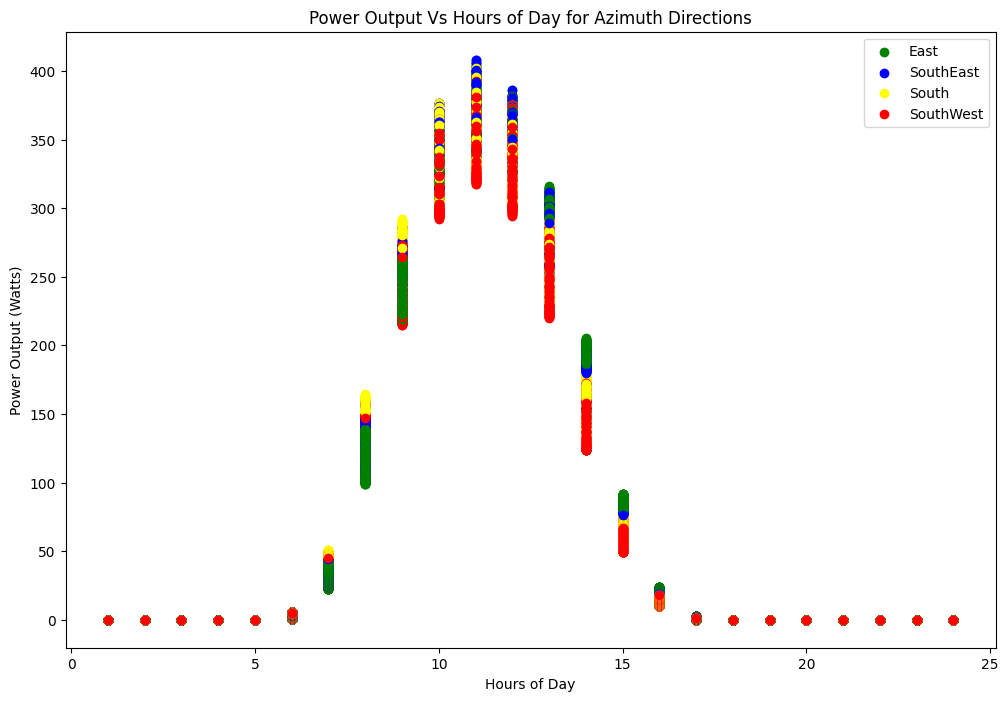

In [31]:
plt.figure(figsize=(12,8))

plt.scatter(hours_of_Day[0], Photovoltaics_Power_East[0], color='green', label='East')
plt.scatter(hours_of_Day[0], Photovoltaics_Power_SouthEast[0], color='blue', label='SouthEast')
plt.scatter(hours_of_Day[0], Photovoltaics_Power_South[0], color='yellow', label='South')
plt.scatter(hours_of_Day[0], Photovoltaics_Power_SouthWest[0], color='red', label='SouthWest')

for i in range(1, len(Photovoltaics_Power_East)):
    plt.scatter(hours_of_Day[i], Photovoltaics_Power_East[i], color='green')
    plt.scatter(hours_of_Day[i], Photovoltaics_Power_SouthEast[i], color='blue')
    plt.scatter(hours_of_Day[i], Photovoltaics_Power_South[i], color='yellow')
    plt.scatter(hours_of_Day[i], Photovoltaics_Power_SouthWest[i], color='red')


plt.xlabel('Hours of Day')
plt.ylabel('Power Output (Watts)')
plt.title('Power Output Vs Hours of Day for Azimuth Directions')
plt.legend()
plt.show()

## Degradation and Financial Analysis Without Battery Installation 

In [32]:
CostPerKwh_grid = value(model.costofKWh_grid)
CostPerKwh_generators = value(model.costofKWh_gen)

 
PV_warranty_period = 25  # years
Years_Considered = np.arange(25)

### First Scenario 

In [33]:
# New_PV_Power_East_S1 = np.array(list(inner_dict for inner_dict in results[0]['Hourly_New_PV_Power_East'].values()))
# New_PV_Power_SouthEast_S1 = np.array(list(inner_dict for inner_dict in results[0]['Hourly_New_PV_Power_SouthEast'].values()))
# New_PV_Power_South_S1 = np.array(list(inner_dict for inner_dict in results[0]['Hourly_New_PV_Power_South'].values()))
# New_PV_Power_SouthWest_S1 = np.array(list(inner_dict for inner_dict in results[0]['Hourly_New_PV_Power_SouthWest'].values()))
# Exisitng_PV_Power_S1 = np.array(list(inner_dict for inner_dict in results[0]['Hourly_Power_Existing_PV'].values()))

# Grid_Power_S1 = np.array(list(inner_dict for inner_dict in results[0]['Hourly_Grid_Power'].values()))
# Gen_Power_S1 = np.array(list(inner_dict for inner_dict in results[0]['Hourly_Gen_Power'].values()))



# New_PV_Energy_production_over_25_years_S1 = np.zeros(PV_warranty_period)
# Existing_PV_Energy_Production_for_Next_18_years_S1 = np.zeros(PV_warranty_period)

# New_PV_Yearly_Savings_S1 = np.zeros(PV_warranty_period)
# New_PV_Yearly_Real_Savings_S1 = np.zeros(PV_warranty_period)

# Existing_PV_Yearly_Savings_S1 = np.zeros(PV_warranty_period)
# Existing_PV_Yearly_Real_Savings_S1 = np.zeros(PV_warranty_period)


# New_PV_Power_degradation_S1 = np.zeros(len(New_PV_Power_East_S1))
# New_PV_Power_Savings_S1 = np.zeros(len(New_PV_Power_East_S1))

# Existing_PV_Power_degradation_S1 = np.zeros(len(New_PV_Power_East_S1))
# Existing_PV_Power_Savings_S1 = np.zeros(len(New_PV_Power_East_S1))

# #Annual_maintenance_cost_S1 = np.insert(np.array([results[0]['Future_PV_Annual_Maintenance_cost']]*24), 0, 0)

# for years in range(PV_warranty_period):
#     Existing_PV_Power_factor = 1
#     First_year_degradation_rate = 0.025   
#     Constant_yearly_degradation_rate = 0.03  
#     Inflaction_Discount_factor = 0.05
    
#     discount_factor = 1/((1 + Inflaction_Discount_factor) ** years)
#     if years == 0:
#         degradation_rate = First_year_degradation_rate
#     else:
#         degradation_rate = Constant_yearly_degradation_rate
        
#     for i in range(len(New_PV_Power_East_S1)):
#         if Grid_Power_S1[i] > 0 and (New_PV_Power_East_S1[i] > 0 or New_PV_Power_SouthEast_S1[i] > 0 or New_PV_Power_South_S1[i] > 0 or New_PV_Power_SouthWest_S1[i] > 0):
#             New_PV_Power_degradation_S1[i] = (value(model.AverageYearly_PowerDemand[i]) - Grid_Power_S1[i] - Exisitng_PV_Power_S1[i]) * ((1 - degradation_rate)**years)
#             New_PV_Power_Savings_S1[i] = New_PV_Power_degradation_S1[i] * CostPerKwh_grid
        
#         if Gen_Power_S1[i] > 0 and (New_PV_Power_East_S1[i] > 0 or New_PV_Power_SouthEast_S1[i] > 0 or New_PV_Power_South_S1[i] > 0 or New_PV_Power_SouthWest_S1[i] > 0):
#             New_PV_Power_degradation_S1[i] = (value(model.AverageYearly_PowerDemand[i]) - Gen_Power_S1[i] - Exisitng_PV_Power_S1[i]) * ((1 - degradation_rate)**years)
#             New_PV_Power_Savings_S1[i] = New_PV_Power_degradation_S1[i] * CostPerKwh_generators
        
#         if Grid_Power_S1[i] > 0 and (Exisitng_PV_Power_S1[i] > 0):
#             degradation_rate = Constant_yearly_degradation_rate
#             Existing_PV_Power_degradation_S1[i] = ((value(model.AverageYearly_PowerDemand[i]) - Grid_Power_S1[i] - (New_PV_Power_East_S1[i] + New_PV_Power_SouthEast_S1[i] + New_PV_Power_South_S1[i] + 
#                                                     New_PV_Power_SouthWest_S1[i])) * ((1 - degradation_rate)**years))
#             Existing_PV_Power_Savings_S1[i] = Existing_PV_Power_degradation_S1[i] * CostPerKwh_grid
        
#         if Gen_Power_S1[i] > 0 and (Exisitng_PV_Power_S1[i] > 0):
#             degradation_rate = Constant_yearly_degradation_rate
#             Existing_PV_Power_degradation_S1[i] = ((value(model.AverageYearly_PowerDemand[i]) - Gen_Power_S1[i] - (New_PV_Power_East_S1[i] + New_PV_Power_SouthEast_S1[i] + New_PV_Power_South_S1[i] + 
#                                                     New_PV_Power_SouthWest_S1[i])) * ((1 - degradation_rate)**years))
#             Existing_PV_Power_Savings_S1[i] = Existing_PV_Power_degradation_S1[i] * CostPerKwh_generators

#     if years > 17:
#         Existing_PV_Power_factor = 0
    
    # New_PV_Energy_production_over_25_years_S1[years] = sum(New_PV_Power_degradation_S1)
    # Existing_PV_Energy_Production_for_Next_18_years_S1[years] = sum(Existing_PV_Power_degradation_S1) * Existing_PV_Power_factor

    # New_PV_Yearly_Savings_S1[years] = sum(New_PV_Power_Savings_S1)
    # Existing_PV_Yearly_Savings_S1[years] = sum(Existing_PV_Power_Savings_S1) * Existing_PV_Power_factor

    # New_PV_Yearly_Real_Savings_S1[years] = (New_PV_Yearly_Savings_S1[years] * discount_factor) #- Annual_maintenance_cost_S1[years]
    # Existing_PV_Yearly_Real_Savings_S1[years] = Existing_PV_Yearly_Savings_S1[years] * discount_factor

In [34]:
# Minimized_Cost_S1 = results[0]['Minimized Cost ($)']
# Yearly_Reduced_Energy_Cost_S1 = np.zeros(PV_warranty_period)
# Yearly_Reduced_Energy_Cost_S1[0] = Minimized_Cost_S1
# for i in range(1, PV_warranty_period):
#     if i == 1:
#         Yearly_Reduced_Energy_Cost_S1[i] = (Yearly_Reduced_Energy_Cost_S1[i-1] - (results[0]['New_PV Capacity (kW)'] * (value(model.costperKW_PV_system + model.costperKW_PV_installation))) - 
#                                            New_PV_Yearly_Real_Savings_S1[i])
#     else:
#         Yearly_Reduced_Energy_Cost_S1[i] = Yearly_Reduced_Energy_Cost_S1[i-1] - New_PV_Yearly_Real_Savings_S1[i]

In [35]:
# Initial_investment_cost_array_S1 = [results[0]['New_PV Capacity (kW)'] * (value(model.costperKW_PV_system + model.costperKW_PV_installation))] * 25
# CumSavings_S1 = np.cumsum(New_PV_Yearly_Real_Savings_S1)

In [36]:
# plt.figure(figsize = (10, 6))
# plt.plot(Years_Considered, Initial_investment_cost_array_S1, color = 'red', label = 'Initial Investment')
# plt.plot(Years_Considered, CumSavings_S1, color = 'blue', label = 'Cummulative Real Savings')
# plt.title('Pay Back Time of Investment for Scenario - 1')
# plt.xlabel('Years')
# plt.ylabel('US Dollars')
# plt.legend()
# plt.show()

In [37]:
# plt.figure(figsize = (10, 6))
# plt.plot(Years_Considered, Yearly_Reduced_Energy_Cost_S1, color="green", label="Yearly Reduced Energy Cost")
# plt.title('Reduction In Energy Cost Over 25 Year for Scenario - 1')
# plt.xlabel('Years')
# plt.ylabel('US Dollars')
# plt.legend()
# plt.show()

### Second Scenario

In [38]:
# New_PV_Power_East_S2 = np.array(list(inner_dict for inner_dict in results[0]['Hourly_New_PV_Power_East'].values()))
# New_PV_Power_SouthEast_S2 = np.array(list(inner_dict for inner_dict in results[0]['Hourly_New_PV_Power_SouthEast'].values()))
# New_PV_Power_South_S2 = np.array(list(inner_dict for inner_dict in results[0]['Hourly_New_PV_Power_South'].values()))
# New_PV_Power_SouthWest_S2 = np.array(list(inner_dict for inner_dict in results[0]['Hourly_New_PV_Power_SouthWest'].values()))
# Existing_PV_Power_S2 = np.array(list(inner_dict for inner_dict in results[0]['Hourly_Power_Existing_PV'].values()))

# Grid_Power_S2 = np.array(list(inner_dict for inner_dict in results[0]['Hourly_Grid_Power'].values()))
# Gen_Power_S2 = np.array(list(inner_dict for inner_dict in results[0]['Hourly_Gen_Power'].values()))


New_PV_Power_East_S2 = np.array([inner_dict for inner_dict in results[0]['Hourly_New_PV_Power_East'].values()])
New_PV_Power_SouthEast_S2 = np.array([inner_dict for inner_dict in results[0]['Hourly_New_PV_Power_SouthEast'].values()])
New_PV_Power_South_S2 = np.array([inner_dict for inner_dict in results[0]['Hourly_New_PV_Power_South'].values()])
New_PV_Power_SouthWest_S2 = np.array([inner_dict for inner_dict in results[0]['Hourly_New_PV_Power_SouthWest'].values()])
Existing_PV_Power_S2 = np.array([inner_dict for inner_dict in results[0]['Hourly_Power_Existing_PV'].values()])

Grid_Power_S2 = np.array([inner_dict for inner_dict in results[1]['Hourly_Grid_Power'].values()])
Gen_Power_S2 = np.array([inner_dict for inner_dict in results[1]['Hourly_Gen_Power'].values()])



New_PV_Energy_production_over_25_years_S2 = np.zeros(PV_warranty_period)
Existing_PV_Energy_Production_for_Next_18_years_S2 = np.zeros(PV_warranty_period)

New_PV_Yearly_Savings_S2 = np.zeros(PV_warranty_period)
New_PV_Yearly_Real_Savings_S2 = np.zeros(PV_warranty_period)

Existing_PV_Yearly_Savings_S2 = np.zeros(PV_warranty_period)
Existing_PV_Yearly_Real_Savings_S2 = np.zeros(PV_warranty_period)


New_PV_Power_degradation_S2 = np.zeros(len(New_PV_Power_East_S2))
New_PV_Power_Savings_S2 = np.zeros(len(New_PV_Power_East_S2))

Existing_PV_Power_degradation_S2 = np.zeros(len(New_PV_Power_East_S2))
Existing_PV_Power_Savings_S2 = np.zeros(len(New_PV_Power_East_S2))

Annual_maintenance_cost_S2 = np.array([results[0]['Future_PV_Annual_Maintenance_cost']]*25)


for years in range(PV_warranty_period):
    Existing_PV_Power_factor = 1
    First_year_degradation_rate = 0.025   
    Constant_yearly_degradation_rate = 0.01  
    Inflation_Discount_factor = 0.04
    
    discount_factor = 1/((1 + Inflation_Discount_factor) ** years)
    if years == 0:
        degradation_rate = First_year_degradation_rate
    else:
        degradation_rate = Constant_yearly_degradation_rate
        
    for i in range(len(New_PV_Power_East_S2)):
        if Grid_Power_S2[i] > 0 and (New_PV_Power_East_S2[i] > 0 or New_PV_Power_SouthEast_S2[i] > 0 or New_PV_Power_South_S2[i] > 0 or New_PV_Power_SouthWest_S2[i] > 0):
            New_PV_Power_degradation_S2[i] = (value(model.AverageYearly_PowerDemand[i]) - Grid_Power_S2[i] - Existing_PV_Power_S2[i]) * ((1 - degradation_rate)**years)
            New_PV_Power_Savings_S2[i] = New_PV_Power_degradation_S2[i] * CostPerKwh_grid
        
        if Gen_Power_S2[i] > 0 and (New_PV_Power_East_S2[i] > 0 or New_PV_Power_SouthEast_S2[i] > 0 or New_PV_Power_South_S2[i] > 0 or New_PV_Power_SouthWest_S2[i] > 0):
            New_PV_Power_degradation_S2[i] = (value(model.AverageYearly_PowerDemand[i]) - Gen_Power_S2[i] - Existing_PV_Power_S2[i]) * ((1 - degradation_rate)**years)
            New_PV_Power_Savings_S2[i] = New_PV_Power_degradation_S2[i] * CostPerKwh_generators
        
        if Grid_Power_S2[i] > 0 and (Existing_PV_Power_S2[i] > 0):
            degradation_rate = Constant_yearly_degradation_rate
            Existing_PV_Power_degradation_S2[i] = ((value(model.AverageYearly_PowerDemand[i]) - Grid_Power_S2[i] - (New_PV_Power_East_S2[i] + New_PV_Power_SouthEast_S2[i] + New_PV_Power_South_S2[i] + 
                                                    New_PV_Power_SouthWest_S2[i])) * ((1 - degradation_rate)**years))
            Existing_PV_Power_Savings_S2[i] = Existing_PV_Power_degradation_S2[i] * CostPerKwh_grid
        
        if Gen_Power_S2[i] > 0 and (Existing_PV_Power_S2[i] > 0):
            degradation_rate = Constant_yearly_degradation_rate
            Existing_PV_Power_degradation_S2[i] = ((value(model.AverageYearly_PowerDemand[i]) - Gen_Power_S2[i] - (New_PV_Power_East_S2[i] + New_PV_Power_SouthEast_S2[i] + New_PV_Power_South_S2[i] + 
                                                    New_PV_Power_SouthWest_S2[i])) * ((1 - degradation_rate)**years))
            Existing_PV_Power_Savings_S2[i] = Existing_PV_Power_degradation_S2[i] * CostPerKwh_generators

    if years > 17:
        Existing_PV_Power_factor = 0
    
    New_PV_Energy_production_over_25_years_S2[years] = np.sum(New_PV_Power_degradation_S2)
    Existing_PV_Energy_Production_for_Next_18_years_S2[years] = np.sum(Existing_PV_Power_degradation_S2) * Existing_PV_Power_factor

    New_PV_Yearly_Savings_S2[years] = np.sum(New_PV_Power_Savings_S2)
    Existing_PV_Yearly_Savings_S2[years] = np.sum(Existing_PV_Power_Savings_S2) * Existing_PV_Power_factor

    New_PV_Yearly_Real_Savings_S2[years] = (New_PV_Yearly_Savings_S2[years] * discount_factor) - Annual_maintenance_cost_S2[years]
    Existing_PV_Yearly_Real_Savings_S2[years] = Existing_PV_Yearly_Savings_S2[years] * discount_factor

In [39]:
Minimized_Cost_S2 = results[0]['Minimized Cost ($)']
Yearly_Reduced_Energy_Cost_S2 = np.zeros(PV_warranty_period)
Yearly_Reduced_Energy_Cost_S2[0] = Minimized_Cost_S2
for i in range(1, PV_warranty_period):
    if i == 1:
        Yearly_Reduced_Energy_Cost_S2[i] = (Yearly_Reduced_Energy_Cost_S2[i-1] - (results[0]['New_PV_System_Setup_Cost']) - New_PV_Yearly_Real_Savings_S2[i])
    else:
        Yearly_Reduced_Energy_Cost_S2[i] = Yearly_Reduced_Energy_Cost_S2[i-1] - New_PV_Yearly_Real_Savings_S2[i]

In [40]:
Initial_investment_cost_array_S2 = [results[0]['New_PV_System_Setup_Cost']] * 25
CumSavings_S2 = np.cumsum(New_PV_Yearly_Real_Savings_S2)

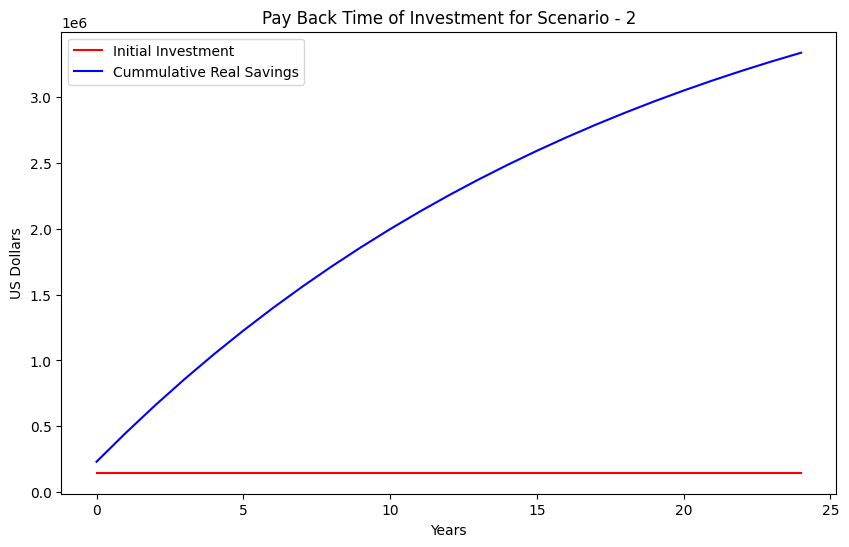

In [41]:
plt.figure(figsize = (10, 6))
plt.plot(Years_Considered, Initial_investment_cost_array_S2, color = 'red', label = 'Initial Investment')
plt.plot(Years_Considered, CumSavings_S2, color = 'blue', label = 'Cummulative Real Savings')
plt.title('Pay Back Time of Investment for Scenario - 2')
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.legend()
plt.show()

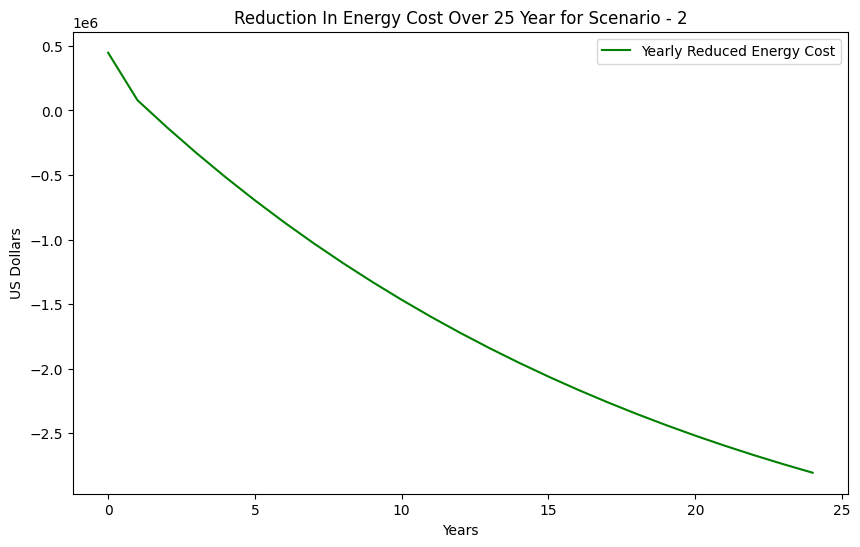

In [42]:
plt.figure(figsize = (10, 6))
plt.plot(Years_Considered, Yearly_Reduced_Energy_Cost_S2, color="green", label="Yearly Reduced Energy Cost")
plt.title('Reduction In Energy Cost Over 25 Year for Scenario - 2')
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.legend()
plt.show()

### Third Scenario

In [43]:
New_PV_Power_East_S3 = np.array([inner_dict for inner_dict in results[1]['Hourly_New_PV_Power_East'].values()])
New_PV_Power_SouthEast_S3 = np.array([inner_dict for inner_dict in results[1]['Hourly_New_PV_Power_SouthEast'].values()])
New_PV_Power_South_S3 = np.array([inner_dict for inner_dict in results[1]['Hourly_New_PV_Power_South'].values()])
New_PV_Power_SouthWest_S3 = np.array([inner_dict for inner_dict in results[1]['Hourly_New_PV_Power_SouthWest'].values()])
Existing_PV_Power_S3 = np.array([inner_dict for inner_dict in results[1]['Hourly_Power_Existing_PV'].values()])

Grid_Power_S3 = np.array([inner_dict for inner_dict in results[1]['Hourly_Grid_Power'].values()])
Gen_Power_S3 = np.array([inner_dict for inner_dict in results[1]['Hourly_Gen_Power'].values()])



New_PV_Energy_production_over_25_years_S3 = np.zeros(PV_warranty_period)
Existing_PV_Energy_Production_for_Next_18_years_S3 = np.zeros(PV_warranty_period)

New_PV_Yearly_Savings_S3 = np.zeros(PV_warranty_period)
New_PV_Yearly_Real_Savings_S3 = np.zeros(PV_warranty_period)

Existing_PV_Yearly_Savings_S3 = np.zeros(PV_warranty_period)
Existing_PV_Yearly_Real_Savings_S3 = np.zeros(PV_warranty_period)


New_PV_Power_degradation_S3 = np.zeros(len(New_PV_Power_East_S3))
New_PV_Power_Savings_S3 = np.zeros(len(New_PV_Power_East_S3))

Existing_PV_Power_degradation_S3 = np.zeros(len(New_PV_Power_East_S3))
Existing_PV_Power_Savings_S3 = np.zeros(len(New_PV_Power_East_S3))

Annual_maintenance_cost_S3 = np.array([results[1]['Future_PV_Annual_Maintenance_cost']]*25)


for years in range(PV_warranty_period):
    Existing_PV_Power_factor = 1
    First_year_degradation_rate = 0.025   
    Constant_yearly_degradation_rate = 0.01  
    Inflation_Discount_factor = 0.04
    
    discount_factor = 1/((1 + Inflation_Discount_factor) ** years)
    if years == 0:
        degradation_rate = First_year_degradation_rate
    else:
        degradation_rate = Constant_yearly_degradation_rate
        
    for i in range(len(New_PV_Power_East_S3)):
        if Grid_Power_S3[i] > 0 and (New_PV_Power_East_S3[i] > 0 or New_PV_Power_SouthEast_S3[i] > 0 or New_PV_Power_South_S3[i] > 0 or New_PV_Power_SouthWest_S3[i] > 0):
            New_PV_Power_degradation_S3[i] = (value(model.AverageYearly_PowerDemand[i]) - Grid_Power_S3[i] - Existing_PV_Power_S3[i]) * ((1 - degradation_rate)**years)
            New_PV_Power_Savings_S3[i] = New_PV_Power_degradation_S3[i] * CostPerKwh_grid
        
        if Gen_Power_S3[i] > 0 and (New_PV_Power_East_S3[i] > 0 or New_PV_Power_SouthEast_S3[i] > 0 or New_PV_Power_South_S3[i] > 0 or New_PV_Power_SouthWest_S3[i] > 0):
            New_PV_Power_degradation_S3[i] = (value(model.AverageYearly_PowerDemand[i]) - Gen_Power_S3[i] - Existing_PV_Power_S3[i]) * ((1 - degradation_rate)**years)
            New_PV_Power_Savings_S3[i] = New_PV_Power_degradation_S3[i] * CostPerKwh_generators
        
        if Grid_Power_S3[i] > 0 and (Existing_PV_Power_S3[i] > 0):
            degradation_rate = Constant_yearly_degradation_rate
            Existing_PV_Power_degradation_S3[i] = ((value(model.AverageYearly_PowerDemand[i]) - Grid_Power_S3[i] - (New_PV_Power_East_S3[i] + New_PV_Power_SouthEast_S3[i] + New_PV_Power_South_S3[i] + 
                                                    New_PV_Power_SouthWest_S3[i])) * ((1 - degradation_rate)**years))
            Existing_PV_Power_Savings_S3[i] = Existing_PV_Power_degradation_S3[i] * CostPerKwh_grid
        
        if Gen_Power_S3[i] > 0 and (Existing_PV_Power_S3[i] > 0):
            degradation_rate = Constant_yearly_degradation_rate
            Existing_PV_Power_degradation_S3[i] = ((value(model.AverageYearly_PowerDemand[i]) - Gen_Power_S3[i] - (New_PV_Power_East_S3[i] + New_PV_Power_SouthEast_S3[i] + New_PV_Power_South_S3[i] + 
                                                    New_PV_Power_SouthWest_S3[i])) * ((1 - degradation_rate)**years))
            Existing_PV_Power_Savings_S3[i] = Existing_PV_Power_degradation_S3[i] * CostPerKwh_generators

    if years > 17:
        Existing_PV_Power_factor = 0
    
    New_PV_Energy_production_over_25_years_S3[years] = np.sum(New_PV_Power_degradation_S3)
    Existing_PV_Energy_Production_for_Next_18_years_S3[years] = np.sum(Existing_PV_Power_degradation_S3) * Existing_PV_Power_factor

    New_PV_Yearly_Savings_S3[years] = np.sum(New_PV_Power_Savings_S3)
    Existing_PV_Yearly_Savings_S3[years] = np.sum(Existing_PV_Power_Savings_S3) * Existing_PV_Power_factor

    New_PV_Yearly_Real_Savings_S3[years] = (New_PV_Yearly_Savings_S3[years] * discount_factor) - Annual_maintenance_cost_S3[years]
    Existing_PV_Yearly_Real_Savings_S3[years] = Existing_PV_Yearly_Savings_S3[years] * discount_factor

In [44]:
Minimized_Cost_S3 = results[1]['Minimized Cost ($)']
Yearly_Reduced_Energy_Cost_S3 = np.zeros(PV_warranty_period)
Yearly_Reduced_Energy_Cost_S3[0] = Minimized_Cost_S3
for i in range(1, PV_warranty_period):
    if i == 1:
        Yearly_Reduced_Energy_Cost_S3[i] = (Yearly_Reduced_Energy_Cost_S3[i-1] - (results[1]['New_PV_System_Setup_Cost']) - New_PV_Yearly_Real_Savings_S3[i])
    else:
        Yearly_Reduced_Energy_Cost_S3[i] = Yearly_Reduced_Energy_Cost_S3[i-1] - New_PV_Yearly_Real_Savings_S3[i]

In [45]:
Initial_investment_cost_array_S3 = [results[1]['New_PV_System_Setup_Cost']] * 25
CumSavings_S3 = np.cumsum(New_PV_Yearly_Real_Savings_S3)

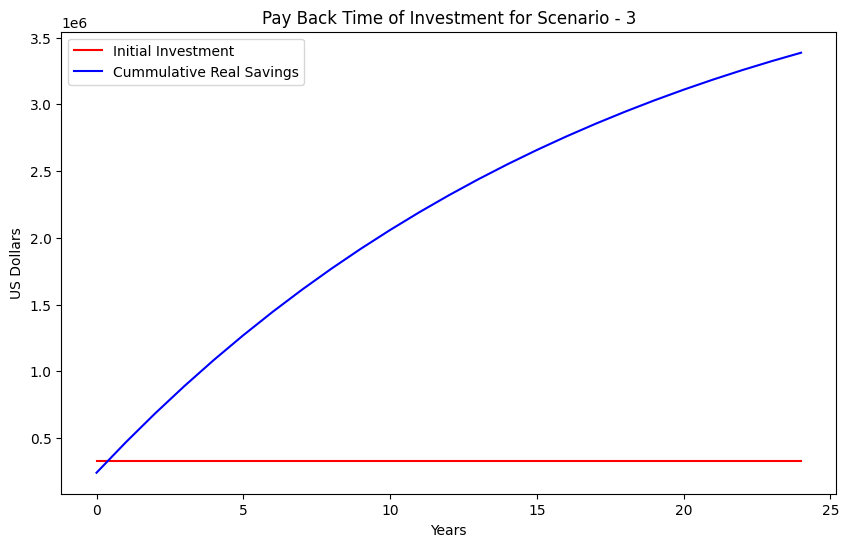

In [46]:
plt.figure(figsize = (10, 6))
plt.plot(Years_Considered, Initial_investment_cost_array_S3, color = 'red', label = 'Initial Investment')
plt.plot(Years_Considered, CumSavings_S3, color = 'blue', label = 'Cummulative Real Savings')
plt.title('Pay Back Time of Investment for Scenario - 3')
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.legend()
plt.show()

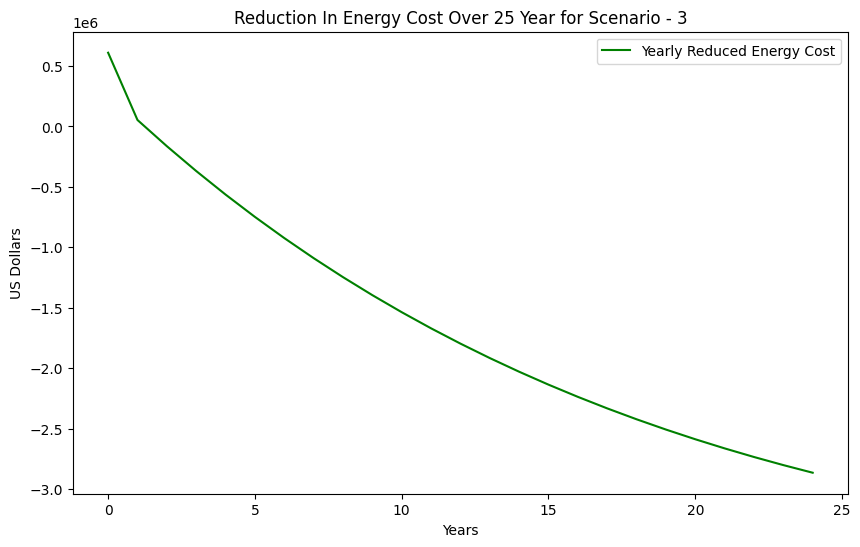

In [47]:
plt.figure(figsize = (10, 6))
plt.plot(Years_Considered, Yearly_Reduced_Energy_Cost_S3, color="green", label="Yearly Reduced Energy Cost")
plt.title('Reduction In Energy Cost Over 25 Year for Scenario - 3')
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.legend()
plt.show()

### Fourth Scenario

In [48]:
New_PV_Power_East_S4 = np.array([inner_dict for inner_dict in results[2]['Hourly_New_PV_Power_East'].values()])
New_PV_Power_SouthEast_S4 = np.array([inner_dict for inner_dict in results[2]['Hourly_New_PV_Power_SouthEast'].values()])
New_PV_Power_South_S4 = np.array([inner_dict for inner_dict in results[2]['Hourly_New_PV_Power_South'].values()])
New_PV_Power_SouthWest_S4 = np.array([inner_dict for inner_dict in results[2]['Hourly_New_PV_Power_SouthWest'].values()])
Existing_PV_Power_S4 = np.array([inner_dict for inner_dict in results[2]['Hourly_Power_Existing_PV'].values()])

Grid_Power_S4 = np.array([inner_dict for inner_dict in results[2]['Hourly_Grid_Power'].values()])
Gen_Power_S4 = np.array([inner_dict for inner_dict in results[2]['Hourly_Gen_Power'].values()])



New_PV_Energy_production_over_25_years_S4 = np.zeros(PV_warranty_period)
Existing_PV_Energy_Production_for_Next_18_years_S4 = np.zeros(PV_warranty_period)

New_PV_Yearly_Savings_S4 = np.zeros(PV_warranty_period)
New_PV_Yearly_Real_Savings_S4 = np.zeros(PV_warranty_period)

Existing_PV_Yearly_Savings_S4 = np.zeros(PV_warranty_period)
Existing_PV_Yearly_Real_Savings_S4 = np.zeros(PV_warranty_period)


New_PV_Power_degradation_S4 = np.zeros(len(New_PV_Power_SouthEast_S4))
New_PV_Power_Savings_S4 = np.zeros(len(New_PV_Power_SouthEast_S4))

Existing_PV_Power_degradation_S4 = np.zeros(len(New_PV_Power_SouthEast_S4))
Existing_PV_Power_Savings_S4 = np.zeros(len(New_PV_Power_SouthEast_S4))

Annual_maintenance_cost_S4 = np.array([results[2]['Future_PV_Annual_Maintenance_cost']]*25)

for years in range(PV_warranty_period):
    Existing_PV_Power_factor = 1
    First_year_degradation_rate = 0.025   
    Constant_yearly_degradation_rate = 0.01  
    Inflation_Discount_factor = 0.04
    
    discount_factor = 1/((1 + Inflation_Discount_factor) ** years)
    if years == 1:
        degradation_rate = First_year_degradation_rate
    
    else:
        degradation_rate = Constant_yearly_degradation_rate
        
    for i in range(len(New_PV_Power_East_S4)):
        if Grid_Power_S4[i] > 0 and (New_PV_Power_East_S4[i] > 0 or New_PV_Power_SouthEast_S4[i] > 0 or New_PV_Power_South_S4[i] > 0 or New_PV_Power_SouthWest_S4[i] > 0):
            New_PV_Power_degradation_S4[i] = (value(model.AverageYearly_PowerDemand[i]) - Grid_Power_S4[i] - Existing_PV_Power_S4[i]) * ((1 - degradation_rate)**years)
            New_PV_Power_Savings_S4[i] = New_PV_Power_degradation_S4[i] * CostPerKwh_grid
        
        if Gen_Power_S4[i] > 0 and (New_PV_Power_East_S4[i] > 0 or New_PV_Power_SouthEast_S4[i] > 0 or New_PV_Power_South_S4[i] > 0 or New_PV_Power_SouthWest_S4[i] > 0):
            New_PV_Power_degradation_S4[i] = (value(model.AverageYearly_PowerDemand[i]) - Gen_Power_S4[i] - Existing_PV_Power_S4[i]) * ((1 - degradation_rate)**years)
            New_PV_Power_Savings_S4[i] = New_PV_Power_degradation_S4[i] * CostPerKwh_generators
        
        if Grid_Power_S4[i] > 0 and (Existing_PV_Power_S4[i] > 0):
            degradation_rate = Constant_yearly_degradation_rate
            Existing_PV_Power_degradation_S4[i] = ((value(model.AverageYearly_PowerDemand[i]) - Grid_Power_S4[i] - (New_PV_Power_East_S4[i] + New_PV_Power_SouthEast_S4[i] + New_PV_Power_South_S4[i] + 
                                                    New_PV_Power_SouthWest_S4[i])) * ((1 - degradation_rate)**years))
            Existing_PV_Power_Savings_S4[i] = Existing_PV_Power_degradation_S4[i] * CostPerKwh_grid
        
        if Gen_Power_S4[i] > 0 and (Existing_PV_Power_S4[i] > 0):
            degradation_rate = Constant_yearly_degradation_rate
            Existing_PV_Power_degradation_S4[i] = ((value(model.AverageYearly_PowerDemand[i]) - Gen_Power_S4[i] - (New_PV_Power_East_S4[i] + New_PV_Power_SouthEast_S4[i] + New_PV_Power_South_S4[i] + 
                                                    New_PV_Power_SouthWest_S4[i])) * ((1 - degradation_rate)**years))
            Existing_PV_Power_Savings_S4[i] = Existing_PV_Power_degradation_S4[i] * CostPerKwh_generators

    if years > 17:
        Existing_PV_Power_factor = 0
        
    New_PV_Energy_production_over_25_years_S4[years] = np.sum(New_PV_Power_degradation_S4)
    Existing_PV_Energy_Production_for_Next_18_years_S4[years] = np.sum(Existing_PV_Power_degradation_S4) * Existing_PV_Power_factor

    New_PV_Yearly_Savings_S4[years] = np.sum(New_PV_Power_Savings_S4)
    Existing_PV_Yearly_Savings_S4[years] = np.sum(Existing_PV_Power_Savings_S4) * Existing_PV_Power_factor

    New_PV_Yearly_Real_Savings_S4[years] = (New_PV_Yearly_Savings_S4[years] * discount_factor) - Annual_maintenance_cost_S4[years]
    Existing_PV_Yearly_Real_Savings_S4[years] = Existing_PV_Yearly_Savings_S4[years] * discount_factor

In [49]:
Minimized_Cost_S4 = results[2]['Minimized Cost ($)']
Yearly_Reduced_Energy_Cost_S4 = np.zeros(PV_warranty_period)
Yearly_Reduced_Energy_Cost_S4[0] = Minimized_Cost_S4
for i in range(1, PV_warranty_period):
    if i == 1:
        Yearly_Reduced_Energy_Cost_S4[i] = (Yearly_Reduced_Energy_Cost_S4[i-1] - (results[2]['New_PV_System_Setup_Cost']) - New_PV_Yearly_Real_Savings_S4[i])
    else:
        Yearly_Reduced_Energy_Cost_S4[i] = Yearly_Reduced_Energy_Cost_S4[i-1] - New_PV_Yearly_Real_Savings_S4[i]

In [50]:
Initial_investment_cost_array_S4 = [results[2]['New_PV_System_Setup_Cost']] * 25
CumSavings_S4 = np.cumsum(New_PV_Yearly_Real_Savings_S4)

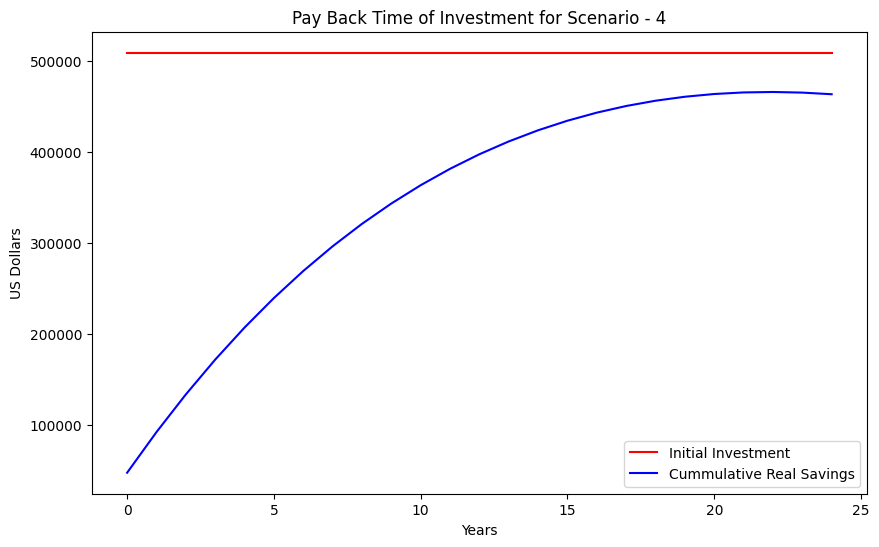

In [51]:
plt.figure(figsize = (10, 6))
plt.plot(Years_Considered, Initial_investment_cost_array_S4, color = 'red', label = 'Initial Investment')
plt.plot(Years_Considered, CumSavings_S4, color = 'blue', label = 'Cummulative Real Savings')
plt.title('Pay Back Time of Investment for Scenario - 4')
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.legend()
plt.show()

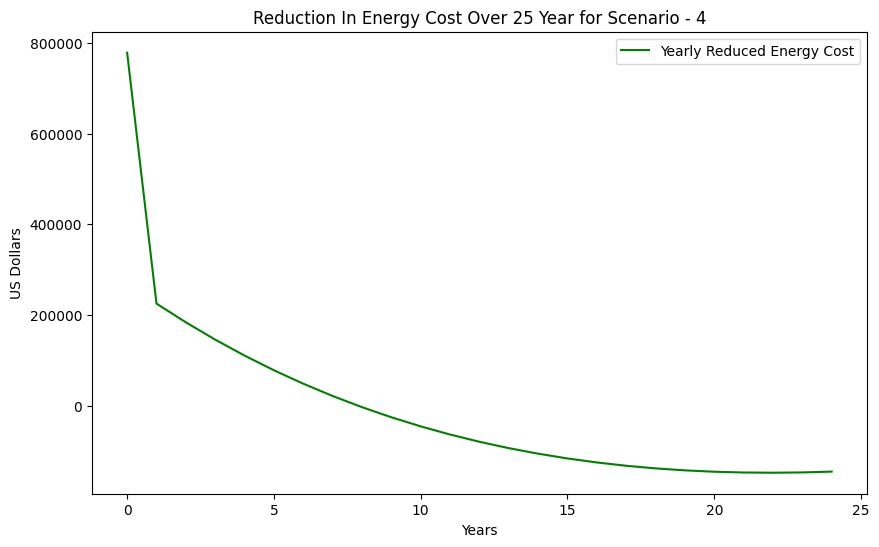

In [52]:
plt.figure(figsize = (10, 6))
plt.plot(Years_Considered, Yearly_Reduced_Energy_Cost_S4, color="green", label="Yearly Reduced Energy Cost")
plt.title('Reduction In Energy Cost Over 25 Year for Scenario - 4')
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.legend()
plt.show()

### Fifth Scenario

In [53]:
New_PV_Power_East_S5 = np.array([inner_dict for inner_dict in results[3]['Hourly_New_PV_Power_East'].values()])
New_PV_Power_SouthEast_S5 = np.array([inner_dict for inner_dict in results[3]['Hourly_New_PV_Power_SouthEast'].values()])
New_PV_Power_South_S5 = np.array([inner_dict for inner_dict in results[3]['Hourly_New_PV_Power_South'].values()])
New_PV_Power_SouthWest_S5 = np.array([inner_dict for inner_dict in results[3]['Hourly_New_PV_Power_SouthWest'].values()])
Existing_PV_Power_S5 = np.array([inner_dict for inner_dict in results[3]['Hourly_Power_Existing_PV'].values()])

Grid_Power_S5 = np.array([inner_dict for inner_dict in results[3]['Hourly_Grid_Power'].values()])
Gen_Power_S5 = np.array([inner_dict for inner_dict in results[3]['Hourly_Gen_Power'].values()])



New_PV_Energy_production_over_25_years_S5 = np.zeros(PV_warranty_period)
Existing_PV_Energy_Production_for_Next_18_years_S5 = np.zeros(PV_warranty_period)

New_PV_Yearly_Savings_S5 = np.zeros(PV_warranty_period)
New_PV_Yearly_Real_Savings_S5 = np.zeros(PV_warranty_period)

Existing_PV_Yearly_Savings_S5 = np.zeros(PV_warranty_period)
Existing_PV_Yearly_Real_Savings_S5 = np.zeros(PV_warranty_period)


New_PV_Power_degradation_S5 = np.zeros(len(New_PV_Power_SouthEast_S5))
New_PV_Power_Savings_S5 = np.zeros(len(New_PV_Power_SouthEast_S5))

Existing_PV_Power_degradation_S5 = np.zeros(len(New_PV_Power_SouthEast_S5))
Existing_PV_Power_Savings_S5 = np.zeros(len(New_PV_Power_SouthEast_S5))

Annual_maintenance_cost_S5 = np.array([results[3]['Future_PV_Annual_Maintenance_cost']]*25)

for years in range(PV_warranty_period):
    Existing_PV_Power_factor = 1
    First_year_degradation_rate = 0.025   
    Constant_yearly_degradation_rate = 0.01  
    Inflation_Discount_factor = 0.04
    
    discount_factor = 1/((1 + Inflation_Discount_factor) ** years)
    if years == 1:
        degradation_rate = First_year_degradation_rate
    
    else:
        degradation_rate = Constant_yearly_degradation_rate
        
    for i in range(len(New_PV_Power_East_S5)):
        if Grid_Power_S5[i] > 0 and (New_PV_Power_East_S5[i] > 0 or New_PV_Power_SouthEast_S5[i] > 0 or New_PV_Power_South_S5[i] > 0 or New_PV_Power_SouthWest_S5[i] > 0):
            New_PV_Power_degradation_S5[i] = (value(model.AverageYearly_PowerDemand[i]) - Grid_Power_S5[i] - Existing_PV_Power_S5[i]) * ((1 - degradation_rate)**years)
            New_PV_Power_Savings_S5[i] = New_PV_Power_degradation_S5[i] * CostPerKwh_grid
        
        if Gen_Power_S5[i] > 0 and (New_PV_Power_East_S5[i] > 0 or New_PV_Power_SouthEast_S5[i] > 0 or New_PV_Power_South_S5[i] > 0 or New_PV_Power_SouthWest_S5[i] > 0):
            New_PV_Power_degradation_S5[i] = (value(model.AverageYearly_PowerDemand[i]) - Gen_Power_S5[i] - Existing_PV_Power_S5[i]) * ((1 - degradation_rate)**years)
            New_PV_Power_Savings_S5[i] = New_PV_Power_degradation_S5[i] * CostPerKwh_generators
        
        if Grid_Power_S5[i] > 0 and (Existing_PV_Power_S5[i] > 0):
            degradation_rate = Constant_yearly_degradation_rate
            Existing_PV_Power_degradation_S5[i] = ((value(model.AverageYearly_PowerDemand[i]) - Grid_Power_S5[i] - (New_PV_Power_East_S5[i] + New_PV_Power_SouthEast_S5[i] + New_PV_Power_South_S5[i] + 
                                                    New_PV_Power_SouthWest_S5[i])) * ((1 - degradation_rate)**years))
            Existing_PV_Power_Savings_S5[i] = Existing_PV_Power_degradation_S5[i] * CostPerKwh_grid
        
        if Gen_Power_S5[i] > 0 and (Existing_PV_Power_S5[i] > 0):
            degradation_rate = Constant_yearly_degradation_rate
            Existing_PV_Power_degradation_S5[i] = ((value(model.AverageYearly_PowerDemand[i]) - Gen_Power_S5[i] - (New_PV_Power_East_S5[i] + New_PV_Power_SouthEast_S5[i] + New_PV_Power_South_S5[i] + 
                                                    New_PV_Power_SouthWest_S5[i])) * ((1 - degradation_rate)**years))
            Existing_PV_Power_Savings_S5[i] = Existing_PV_Power_degradation_S5[i] * CostPerKwh_generators

    if years > 17:
        Existing_PV_Power_factor = 0
        
    New_PV_Energy_production_over_25_years_S5[years] = np.sum(New_PV_Power_degradation_S5)
    Existing_PV_Energy_Production_for_Next_18_years_S5[years] = np.sum(Existing_PV_Power_degradation_S5) * Existing_PV_Power_factor

    New_PV_Yearly_Savings_S5[years] = np.sum(New_PV_Power_Savings_S5)
    Existing_PV_Yearly_Savings_S5[years] = np.sum(Existing_PV_Power_Savings_S5) * Existing_PV_Power_factor

    New_PV_Yearly_Real_Savings_S5[years] = (New_PV_Yearly_Savings_S5[years] * discount_factor) - Annual_maintenance_cost_S5[years]
    Existing_PV_Yearly_Real_Savings_S5[years] = Existing_PV_Yearly_Savings_S5[years] * discount_factor

In [54]:
Minimized_Cost_S5 = results[3]['Minimized Cost ($)']
Yearly_Reduced_Energy_Cost_S5 = np.zeros(PV_warranty_period)
Yearly_Reduced_Energy_Cost_S5[0] = Minimized_Cost_S5
for i in range(1, PV_warranty_period):
    if i == 1:
        Yearly_Reduced_Energy_Cost_S5[i] = (Yearly_Reduced_Energy_Cost_S5[i-1] - (results[3]['New_PV_System_Setup_Cost']) - New_PV_Yearly_Real_Savings_S5[i])
    else:
        Yearly_Reduced_Energy_Cost_S5[i] = Yearly_Reduced_Energy_Cost_S5[i-1] - New_PV_Yearly_Real_Savings_S5[i]

In [55]:
Initial_investment_cost_array_S5 = [results[3]['New_PV_System_Setup_Cost']] * 25
CumSavings_S5 = np.cumsum(New_PV_Yearly_Real_Savings_S5)

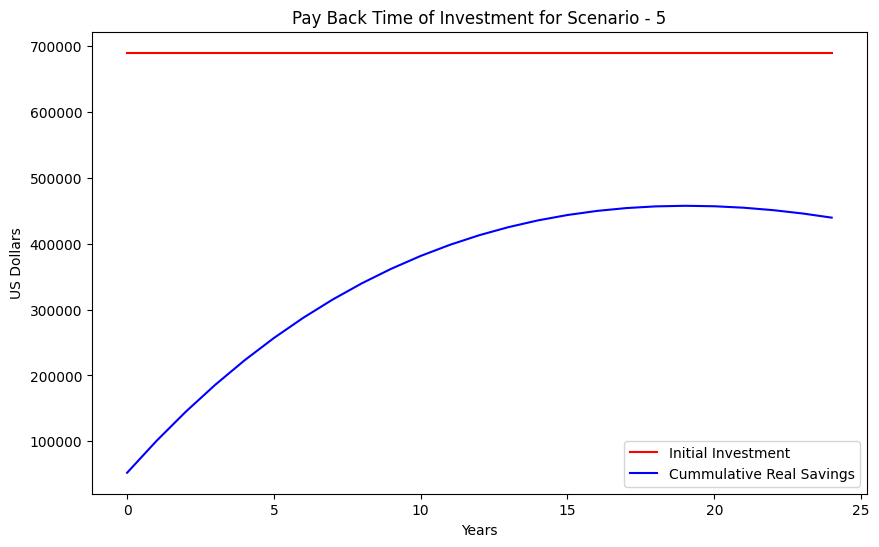

In [56]:
plt.figure(figsize = (10, 6))
plt.plot(Years_Considered, Initial_investment_cost_array_S5, color = 'red', label = 'Initial Investment')
plt.plot(Years_Considered, CumSavings_S5, color = 'blue', label = 'Cummulative Real Savings')
plt.title('Pay Back Time of Investment for Scenario - 5')
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.legend()
plt.show()

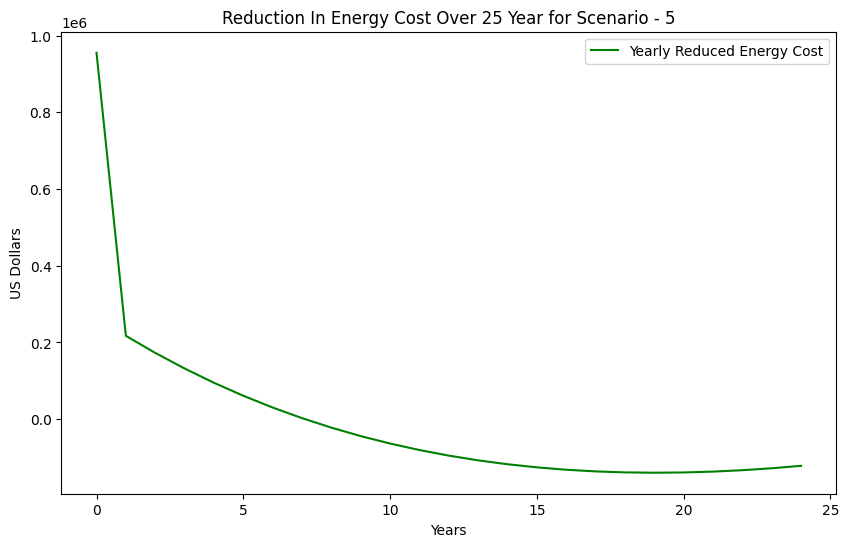

In [57]:
plt.figure(figsize = (10, 6))
plt.plot(Years_Considered, Yearly_Reduced_Energy_Cost_S5, color="green", label="Yearly Reduced Energy Cost")
plt.title('Reduction In Energy Cost Over 25 Year for Scenario - 5')
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.legend()
plt.show()

### Sixth Scenario

In [58]:
New_PV_Power_East_S6 = np.array([inner_dict for inner_dict in results[4]['Hourly_New_PV_Power_East'].values()])
New_PV_Power_SouthEast_S6 = np.array([inner_dict for inner_dict in results[4]['Hourly_New_PV_Power_SouthEast'].values()])
New_PV_Power_South_S6 = np.array([inner_dict for inner_dict in results[4]['Hourly_New_PV_Power_South'].values()])
New_PV_Power_SouthWest_S6 = np.array([inner_dict for inner_dict in results[4]['Hourly_New_PV_Power_SouthWest'].values()])
Existing_PV_Power_S6 = np.array([inner_dict for inner_dict in results[4]['Hourly_Power_Existing_PV'].values()])

Grid_Power_S6 = np.array([inner_dict for inner_dict in results[4]['Hourly_Grid_Power'].values()])
Gen_Power_S6 = np.array([inner_dict for inner_dict in results[4]['Hourly_Gen_Power'].values()])



New_PV_Energy_production_over_25_years_S6 = np.zeros(PV_warranty_period)
Existing_PV_Energy_Production_for_Next_18_years_S6 = np.zeros(PV_warranty_period)

New_PV_Yearly_Savings_S6 = np.zeros(PV_warranty_period)
New_PV_Yearly_Real_Savings_S6 = np.zeros(PV_warranty_period)

Existing_PV_Yearly_Savings_S6 = np.zeros(PV_warranty_period)
Existing_PV_Yearly_Real_Savings_S6 = np.zeros(PV_warranty_period)


New_PV_Power_degradation_S6 = np.zeros(len(New_PV_Power_East_S6))
New_PV_Power_Savings_S6 = np.zeros(len(New_PV_Power_East_S6))

Existing_PV_Power_degradation_S6 = np.zeros(len(New_PV_Power_East_S6))
Existing_PV_Power_Savings_S6 = np.zeros(len(New_PV_Power_East_S6))

Annual_maintenance_cost_S6 = np.array([results[4]['Future_PV_Annual_Maintenance_cost']]*25)

for years in range(PV_warranty_period):
    Existing_PV_Power_factor = 1
    First_year_degradation_rate = 0.025   
    Constant_yearly_degradation_rate = 0.01  
    Inflation_Discount_factor = 0.04
    
    discount_factor = 1/((1 + Inflation_Discount_factor) ** years)
    if years == 1:
        degradation_rate = First_year_degradation_rate
    
    else:
        degradation_rate = Constant_yearly_degradation_rate
        
    for i in range(len(New_PV_Power_East_S6)):
        if Grid_Power_S6[i] > 0 and (New_PV_Power_East_S6[i] > 0 or New_PV_Power_SouthEast_S6[i] > 0 or New_PV_Power_South_S6[i] > 0 or New_PV_Power_SouthWest_S6[i] > 0):
            New_PV_Power_degradation_S6[i] = (value(model.AverageYearly_PowerDemand[i]) - Grid_Power_S6[i] - Existing_PV_Power_S6[i]) * ((1 - degradation_rate)**years)
            New_PV_Power_Savings_S6[i] = New_PV_Power_degradation_S6[i] * CostPerKwh_grid
        
        if Gen_Power_S6[i] > 0 and (New_PV_Power_East_S6[i] > 0 or New_PV_Power_SouthEast_S6[i] > 0 or New_PV_Power_South_S6[i] > 0 or New_PV_Power_SouthWest_S6[i] > 0):
            New_PV_Power_degradation_S6[i] = (value(model.AverageYearly_PowerDemand[i]) - Gen_Power_S6[i] - Existing_PV_Power_S6[i]) * ((1 - degradation_rate)**years)
            New_PV_Power_Savings_S6[i] = New_PV_Power_degradation_S6[i] * CostPerKwh_generators
        
        if Grid_Power_S6[i] > 0 and (Existing_PV_Power_S6[i] > 0):
            degradation_rate = Constant_yearly_degradation_rate
            Existing_PV_Power_degradation_S6[i] = ((value(model.AverageYearly_PowerDemand[i]) - Grid_Power_S6[i] - (New_PV_Power_East_S6[i] + New_PV_Power_SouthEast_S6[i] + New_PV_Power_South_S6[i] + 
                                                    New_PV_Power_SouthWest_S6[i])) * ((1 - degradation_rate)**years))
            Existing_PV_Power_Savings_S6[i] = Existing_PV_Power_degradation_S6[i] * CostPerKwh_grid
        
        if Gen_Power_S6[i] > 0 and (Existing_PV_Power_S6[i] > 0):
            degradation_rate = Constant_yearly_degradation_rate
            Existing_PV_Power_degradation_S6[i] = ((value(model.AverageYearly_PowerDemand[i]) - Gen_Power_S6[i] - (New_PV_Power_East_S6[i] + New_PV_Power_SouthEast_S6[i] + New_PV_Power_South_S6[i] + 
                                                    New_PV_Power_SouthWest_S6[i])) * ((1 - degradation_rate)**years))
            Existing_PV_Power_Savings_S6[i] = Existing_PV_Power_degradation_S6[i] * CostPerKwh_generators

    if years > 17:
        Existing_PV_Power_factor = 0
        
    New_PV_Energy_production_over_25_years_S6[years] = np.sum(New_PV_Power_degradation_S6)
    Existing_PV_Energy_Production_for_Next_18_years_S6[years] = np.sum(Existing_PV_Power_degradation_S6) * Existing_PV_Power_factor

    New_PV_Yearly_Savings_S6[years] = np.sum(New_PV_Power_Savings_S6)
    Existing_PV_Yearly_Savings_S6[years] = np.sum(Existing_PV_Power_Savings_S6) * Existing_PV_Power_factor

    New_PV_Yearly_Real_Savings_S6[years] = (New_PV_Yearly_Savings_S6[years] * discount_factor) - Annual_maintenance_cost_S6[years]
    Existing_PV_Yearly_Real_Savings_S6[years] = Existing_PV_Yearly_Savings_S6[years] * discount_factor

In [59]:
Minimized_Cost_S6 = results[4]['Minimized Cost ($)']
Yearly_Reduced_Energy_Cost_S6 = np.zeros(PV_warranty_period)
Yearly_Reduced_Energy_Cost_S6[0] = Minimized_Cost_S6
for i in range(1, PV_warranty_period):
    if i == 1:
        Yearly_Reduced_Energy_Cost_S6[i] = (Yearly_Reduced_Energy_Cost_S6[i-1] - (results[4]['New_PV_System_Setup_Cost']) - New_PV_Yearly_Real_Savings_S6[i])
    else:
        Yearly_Reduced_Energy_Cost_S6[i] = Yearly_Reduced_Energy_Cost_S6[i-1] - New_PV_Yearly_Real_Savings_S6[i]

In [60]:
Initial_investment_cost_array_S6 = [results[4]['New_PV_System_Setup_Cost']] * 25
CumSavings_S6 = np.cumsum(New_PV_Yearly_Real_Savings_S6)

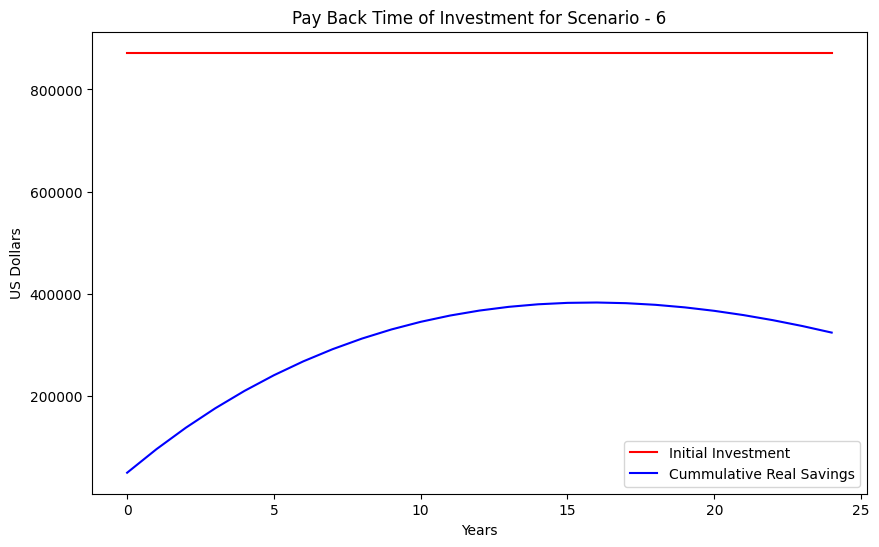

In [61]:
plt.figure(figsize = (10, 6))
plt.plot(Years_Considered, Initial_investment_cost_array_S6, color = 'red', label = 'Initial Investment')
plt.plot(Years_Considered, CumSavings_S6, color = 'blue', label = 'Cummulative Real Savings')
plt.title('Pay Back Time of Investment for Scenario - 6')
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.legend()
plt.show()

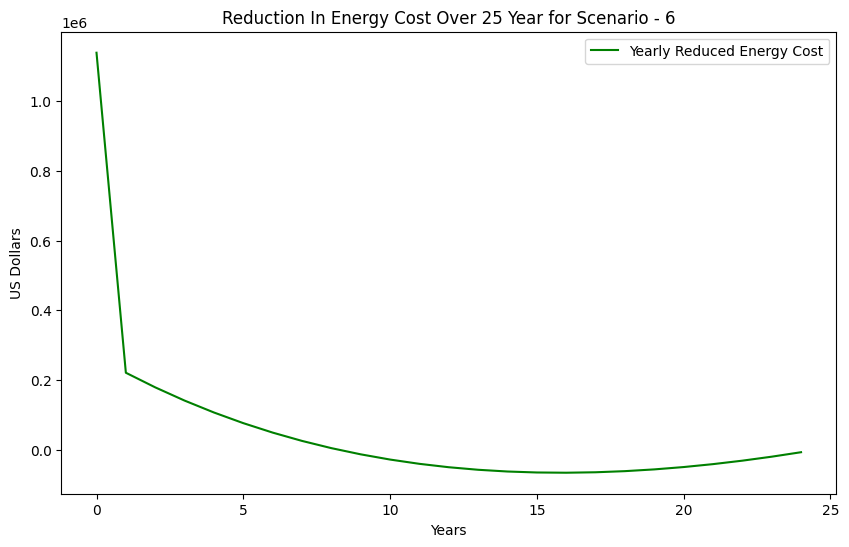

In [62]:
plt.figure(figsize = (10, 6))
plt.plot(Years_Considered, Yearly_Reduced_Energy_Cost_S6, color="green", label="Yearly Reduced Energy Cost")
plt.title('Reduction In Energy Cost Over 25 Year for Scenario - 6')
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.legend()
plt.show()

### Seventh Scenario

In [63]:
New_PV_Power_East_S7 = np.array([inner_dict for inner_dict in results[5]['Hourly_New_PV_Power_East'].values()])
New_PV_Power_SouthEast_S7 = np.array([inner_dict for inner_dict in results[5]['Hourly_New_PV_Power_SouthEast'].values()])
New_PV_Power_South_S7 = np.array([inner_dict for inner_dict in results[5]['Hourly_New_PV_Power_South'].values()])
New_PV_Power_SouthWest_S7 = np.array([inner_dict for inner_dict in results[5]['Hourly_New_PV_Power_SouthWest'].values()])
Existing_PV_Power_S7 = np.array([inner_dict for inner_dict in results[5]['Hourly_Power_Existing_PV'].values()])

Grid_Power_S7 = np.array([inner_dict for inner_dict in results[5]['Hourly_Grid_Power'].values()])
Gen_Power_S7 = np.array([inner_dict for inner_dict in results[5]['Hourly_Gen_Power'].values()])



New_PV_Energy_production_over_25_years_S7 = np.zeros(PV_warranty_period)
Existing_PV_Energy_Production_for_Next_18_years_S7 = np.zeros(PV_warranty_period)

New_PV_Yearly_Savings_S7 = np.zeros(PV_warranty_period)
New_PV_Yearly_Real_Savings_S7 = np.zeros(PV_warranty_period)

Existing_PV_Yearly_Savings_S7 = np.zeros(PV_warranty_period)
Existing_PV_Yearly_Real_Savings_S7 = np.zeros(PV_warranty_period)


New_PV_Power_degradation_S7 = np.zeros(len(New_PV_Power_East_S7))
New_PV_Power_Savings_S7 = np.zeros(len(New_PV_Power_East_S7))

Existing_PV_Power_degradation_S7 = np.zeros(len(New_PV_Power_East_S7))
Existing_PV_Power_Savings_S7 = np.zeros(len(New_PV_Power_East_S7))

Annual_maintenance_cost_S7 = np.array([results[5]['Future_PV_Annual_Maintenance_cost']]*25)

for years in range(PV_warranty_period):
    Existing_PV_Power_factor = 1
    First_year_degradation_rate = 0.025   
    Constant_yearly_degradation_rate = 0.01  
    Inflation_Discount_factor = 0.04
    
    discount_factor = 1/((1 + Inflation_Discount_factor) ** years)
    if years == 1:
        degradation_rate = First_year_degradation_rate
    
    else:
        degradation_rate = Constant_yearly_degradation_rate
        
    for i in range(len(New_PV_Power_East_S6)):
        if Grid_Power_S7[i] > 0 and (New_PV_Power_East_S7[i] > 0 or New_PV_Power_SouthEast_S7[i] > 0 or New_PV_Power_South_S7[i] > 0 or New_PV_Power_SouthWest_S7[i] > 0):
            New_PV_Power_degradation_S7[i] = (value(model.AverageYearly_PowerDemand[i]) - Grid_Power_S7[i] - Existing_PV_Power_S7[i]) * ((1 - degradation_rate)**years)
            New_PV_Power_Savings_S7[i] = New_PV_Power_degradation_S7[i] * CostPerKwh_grid
        
        if Gen_Power_S7[i] > 0 and (New_PV_Power_East_S7[i] > 0 or New_PV_Power_SouthEast_S7[i] > 0 or New_PV_Power_South_S7[i] > 0 or New_PV_Power_SouthWest_S7[i] > 0):
            New_PV_Power_degradation_S7[i] = (value(model.AverageYearly_PowerDemand[i]) - Gen_Power_S7[i] - Existing_PV_Power_S7[i]) * ((1 - degradation_rate)**years)
            New_PV_Power_Savings_S7[i] = New_PV_Power_degradation_S7[i] * CostPerKwh_generators
        
        if Grid_Power_S7[i] > 0 and (Existing_PV_Power_S7[i] > 0):
            degradation_rate = Constant_yearly_degradation_rate
            Existing_PV_Power_degradation_S7[i] = ((value(model.AverageYearly_PowerDemand[i]) - Grid_Power_S7[i] - (New_PV_Power_East_S7[i] + New_PV_Power_SouthEast_S7[i] + New_PV_Power_South_S7[i] + 
                                                    New_PV_Power_SouthWest_S7[i])) * ((1 - degradation_rate)**years))
            Existing_PV_Power_Savings_S7[i] = Existing_PV_Power_degradation_S7[i] * CostPerKwh_grid
        
        if Gen_Power_S7[i] > 0 and (Existing_PV_Power_S7[i] > 0):
            degradation_rate = Constant_yearly_degradation_rate
            Existing_PV_Power_degradation_S7[i] = ((value(model.AverageYearly_PowerDemand[i]) - Gen_Power_S7[i] - (New_PV_Power_East_S7[i] + New_PV_Power_SouthEast_S7[i] + New_PV_Power_South_S7[i] + 
                                                    New_PV_Power_SouthWest_S7[i])) * ((1 - degradation_rate)**years))
            Existing_PV_Power_Savings_S7[i] = Existing_PV_Power_degradation_S7[i] * CostPerKwh_generators

    if years > 17:
        Existing_PV_Power_factor = 0
        
    New_PV_Energy_production_over_25_years_S7[years] = np.sum(New_PV_Power_degradation_S7)
    Existing_PV_Energy_Production_for_Next_18_years_S7[years] = np.sum(Existing_PV_Power_degradation_S7) * Existing_PV_Power_factor

    New_PV_Yearly_Savings_S7[years] = np.sum(New_PV_Power_Savings_S7)
    Existing_PV_Yearly_Savings_S7[years] = np.sum(Existing_PV_Power_Savings_S7) * Existing_PV_Power_factor

    New_PV_Yearly_Real_Savings_S7[years] = (New_PV_Yearly_Savings_S7[years] * discount_factor) - Annual_maintenance_cost_S7[years]
    Existing_PV_Yearly_Real_Savings_S7[years] = Existing_PV_Yearly_Savings_S7[years] * discount_factor

In [64]:
Minimized_Cost_S7 = results[5]['Minimized Cost ($)']
Yearly_Reduced_Energy_Cost_S7 = np.zeros(PV_warranty_period)
Yearly_Reduced_Energy_Cost_S7[0] = Minimized_Cost_S7
for i in range(1, PV_warranty_period):
    if i == 1:
        Yearly_Reduced_Energy_Cost_S7[i] = (Yearly_Reduced_Energy_Cost_S7[i-1] - (results[5]['New_PV_System_Setup_Cost']) - 
                                           New_PV_Yearly_Real_Savings_S7[i])
    else:
        Yearly_Reduced_Energy_Cost_S7[i] = Yearly_Reduced_Energy_Cost_S7[i-1] - New_PV_Yearly_Real_Savings_S7[i]

In [65]:
Initial_investment_cost_array_S7 = [results[5]['New_PV_System_Setup_Cost']] * 25
CumSavings_S7 = np.cumsum(New_PV_Yearly_Real_Savings_S7)

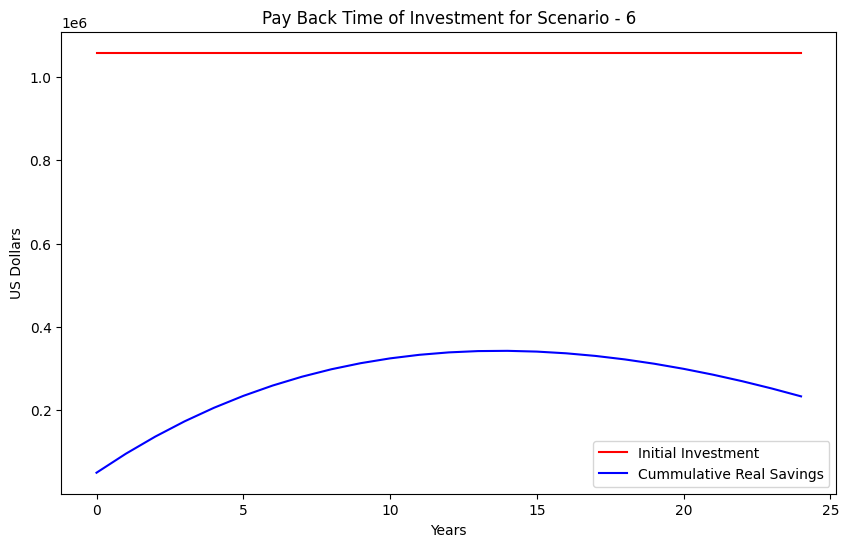

In [66]:
plt.figure(figsize = (10, 6))
plt.plot(Years_Considered, Initial_investment_cost_array_S7, color = 'red', label = 'Initial Investment')
plt.plot(Years_Considered, CumSavings_S7, color = 'blue', label = 'Cummulative Real Savings')
plt.title('Pay Back Time of Investment for Scenario - 6')
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.legend()
plt.show()

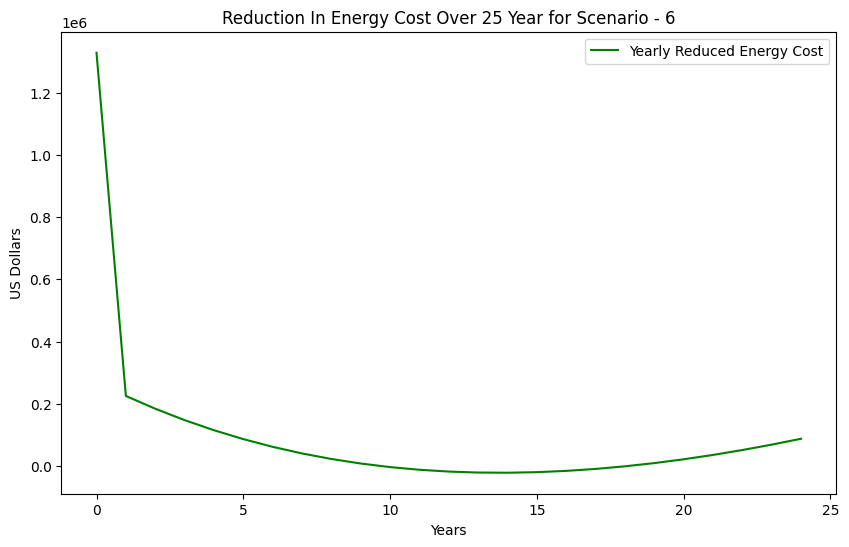

In [67]:
plt.figure(figsize = (10, 6))
plt.plot(Years_Considered, Yearly_Reduced_Energy_Cost_S7, color="green", label="Yearly Reduced Energy Cost")
plt.title('Reduction In Energy Cost Over 25 Year for Scenario - 6')
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.legend()
plt.show()

### Eight Scenario

In [68]:
New_PV_Power_East_S8 = np.array([inner_dict for inner_dict in results[6]['Hourly_New_PV_Power_East'].values()])
New_PV_Power_SouthEast_S8 = np.array([inner_dict for inner_dict in results[6]['Hourly_New_PV_Power_SouthEast'].values()])
New_PV_Power_South_S8 = np.array([inner_dict for inner_dict in results[6]['Hourly_New_PV_Power_South'].values()])
New_PV_Power_SouthWest_S8 = np.array([inner_dict for inner_dict in results[6]['Hourly_New_PV_Power_SouthWest'].values()])
Existing_PV_Power_S8 = np.array([inner_dict for inner_dict in results[6]['Hourly_Power_Existing_PV'].values()])

Grid_Power_S8 = np.array([inner_dict for inner_dict in results[6]['Hourly_Grid_Power'].values()])
Gen_Power_S8 = np.array([inner_dict for inner_dict in results[6]['Hourly_Gen_Power'].values()])



New_PV_Energy_production_over_25_years_S8 = np.zeros(PV_warranty_period)
Existing_PV_Energy_Production_for_Next_18_years_S8 = np.zeros(PV_warranty_period)

New_PV_Yearly_Savings_S8 = np.zeros(PV_warranty_period)
New_PV_Yearly_Real_Savings_S8 = np.zeros(PV_warranty_period)

Existing_PV_Yearly_Savings_S8 = np.zeros(PV_warranty_period)
Existing_PV_Yearly_Real_Savings_S8 = np.zeros(PV_warranty_period)


New_PV_Power_degradation_S8 = np.zeros(len(New_PV_Power_East_S8))
New_PV_Power_Savings_S8 = np.zeros(len(New_PV_Power_East_S8))

Existing_PV_Power_degradation_S8 = np.zeros(len(New_PV_Power_East_S8))
Existing_PV_Power_Savings_S8 = np.zeros(len(New_PV_Power_East_S8))

Annual_maintenance_cost_S8 = np.array([results[6]['Future_PV_Annual_Maintenance_cost']]*25)

for years in range(PV_warranty_period):
    Existing_PV_Power_factor = 1
    First_year_degradation_rate = 0.025   
    Constant_yearly_degradation_rate = 0.01  
    Inflation_Discount_factor = 0.04
    
    discount_factor = 1/((1 + Inflation_Discount_factor) ** years)
    if years == 1:
        degradation_rate = First_year_degradation_rate
    
    else:
        degradation_rate = Constant_yearly_degradation_rate
        
    for i in range(len(New_PV_Power_East_S8)):
        if Grid_Power_S8[i] > 0 and (New_PV_Power_East_S8[i] > 0 or New_PV_Power_SouthEast_S8[i] > 0 or New_PV_Power_South_S8[i] > 0 or New_PV_Power_SouthWest_S8[i] > 0):
            New_PV_Power_degradation_S8[i] = (value(model.AverageYearly_PowerDemand[i]) - Grid_Power_S8[i] - Existing_PV_Power_S8[i]) * ((1 - degradation_rate)**years)
            New_PV_Power_Savings_S8[i] = New_PV_Power_degradation_S8[i] * CostPerKwh_grid
        
        if Gen_Power_S8[i] > 0 and (New_PV_Power_East_S8[i] > 0 or New_PV_Power_SouthEast_S8[i] > 0 or New_PV_Power_South_S8[i] > 0 or New_PV_Power_SouthWest_S8[i] > 0):
            New_PV_Power_degradation_S8[i] = (value(model.AverageYearly_PowerDemand[i]) - Gen_Power_S8[i] - Existing_PV_Power_S8[i]) * ((1 - degradation_rate)**years)
            New_PV_Power_Savings_S8[i] = New_PV_Power_degradation_S8[i] * CostPerKwh_generators
        
        if Grid_Power_S8[i] > 0 and (Existing_PV_Power_S8[i] > 0):
            degradation_rate = Constant_yearly_degradation_rate
            Existing_PV_Power_degradation_S8[i] = ((value(model.AverageYearly_PowerDemand[i]) - Grid_Power_S8[i] - (New_PV_Power_East_S8[i] + New_PV_Power_SouthEast_S8[i] + New_PV_Power_South_S8[i] + 
                                                    New_PV_Power_SouthWest_S8[i])) * ((1 - degradation_rate)**years))
            Existing_PV_Power_Savings_S8[i] = Existing_PV_Power_degradation_S8[i] * CostPerKwh_grid
        
        if Gen_Power_S8[i] > 0 and (Existing_PV_Power_S8[i] > 0):
            degradation_rate = Constant_yearly_degradation_rate
            Existing_PV_Power_degradation_S8[i] = ((value(model.AverageYearly_PowerDemand[i]) - Gen_Power_S8[i] - (New_PV_Power_East_S8[i] + New_PV_Power_SouthEast_S8[i] + New_PV_Power_South_S8[i] + 
                                                    New_PV_Power_SouthWest_S8[i])) * ((1 - degradation_rate)**years))
            Existing_PV_Power_Savings_S8[i] = Existing_PV_Power_degradation_S8[i] * CostPerKwh_generators

    if years > 17:
        Existing_PV_Power_factor = 0
        
    New_PV_Energy_production_over_25_years_S8[years] = np.sum(New_PV_Power_degradation_S8)
    Existing_PV_Energy_Production_for_Next_18_years_S8[years] = np.sum(Existing_PV_Power_degradation_S8) * Existing_PV_Power_factor

    New_PV_Yearly_Savings_S8[years] = np.sum(New_PV_Power_Savings_S8)
    Existing_PV_Yearly_Savings_S8[years] = np.sum(Existing_PV_Power_Savings_S8) * Existing_PV_Power_factor

    New_PV_Yearly_Real_Savings_S8[years] = (New_PV_Yearly_Savings_S8[years] * discount_factor) - Annual_maintenance_cost_S8[years]
    Existing_PV_Yearly_Real_Savings_S8[years] = Existing_PV_Yearly_Savings_S8[years] * discount_factor

In [69]:
Minimized_Cost_S8 = results[6]['Minimized Cost ($)']
Yearly_Reduced_Energy_Cost_S8 = np.zeros(PV_warranty_period)
Yearly_Reduced_Energy_Cost_S8[0] = Minimized_Cost_S8
for i in range(1, PV_warranty_period):
    if i == 1:
        Yearly_Reduced_Energy_Cost_S8[i] = (Yearly_Reduced_Energy_Cost_S8[i-1] - (results[6]['New_PV_System_Setup_Cost']) - New_PV_Yearly_Real_Savings_S8[i])
    else:
        Yearly_Reduced_Energy_Cost_S8[i] = Yearly_Reduced_Energy_Cost_S8[i-1] - New_PV_Yearly_Real_Savings_S8[i]

In [70]:
Initial_investment_cost_array_S8 = [results[6]['New_PV_System_Setup_Cost']] * 25
CumSavings_S8 = np.cumsum(New_PV_Yearly_Real_Savings_S8)

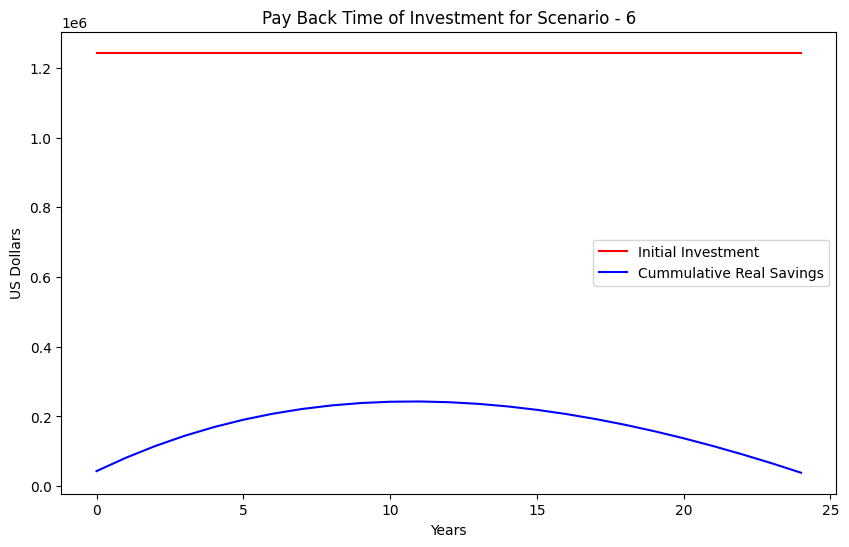

In [71]:
plt.figure(figsize = (10, 6))
plt.plot(Years_Considered, Initial_investment_cost_array_S8, color = 'red', label = 'Initial Investment')
plt.plot(Years_Considered, CumSavings_S8, color = 'blue', label = 'Cummulative Real Savings')
plt.title('Pay Back Time of Investment for Scenario - 6')
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.legend()
plt.show()

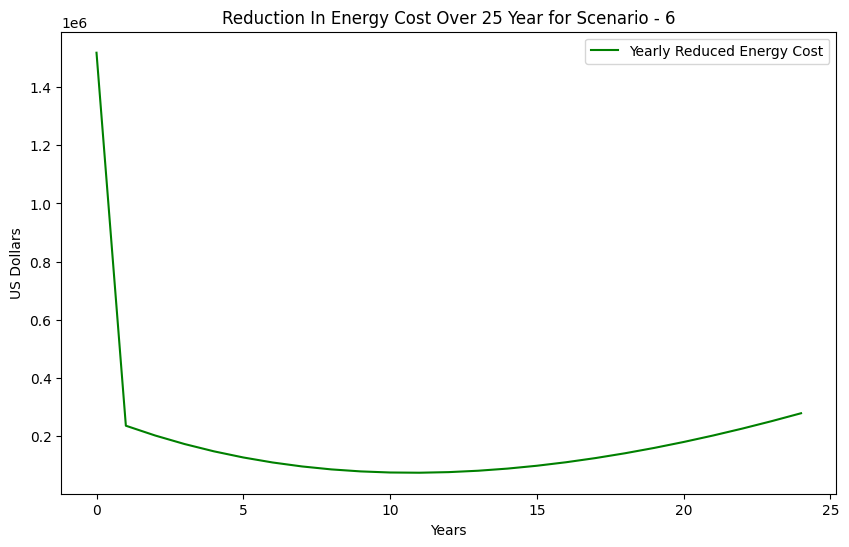

In [72]:
plt.figure(figsize = (10, 6))
plt.plot(Years_Considered, Yearly_Reduced_Energy_Cost_S8, color="green", label="Yearly Reduced Energy Cost")
plt.title('Reduction In Energy Cost Over 25 Year for Scenario - 6')
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.legend()
plt.show()

### Ninth Scenario

In [73]:
New_PV_Power_East_S9 = np.array([inner_dict for inner_dict in results[7]['Hourly_New_PV_Power_East'].values()])
New_PV_Power_SouthEast_S9 = np.array([inner_dict for inner_dict in results[7]['Hourly_New_PV_Power_SouthEast'].values()])
New_PV_Power_South_S9 = np.array([inner_dict for inner_dict in results[7]['Hourly_New_PV_Power_South'].values()])
New_PV_Power_SouthWest_S9 = np.array([inner_dict for inner_dict in results[7]['Hourly_New_PV_Power_SouthWest'].values()])
Existing_PV_Power_S9 = np.array([inner_dict for inner_dict in results[7]['Hourly_Power_Existing_PV'].values()])

Grid_Power_S9 = np.array([inner_dict for inner_dict in results[7]['Hourly_Grid_Power'].values()])
Gen_Power_S9 = np.array([inner_dict for inner_dict in results[7]['Hourly_Gen_Power'].values()])



New_PV_Energy_production_over_25_years_S9 = np.zeros(PV_warranty_period)
Existing_PV_Energy_Production_for_Next_18_years_S9 = np.zeros(PV_warranty_period)

New_PV_Yearly_Savings_S9 = np.zeros(PV_warranty_period)
New_PV_Yearly_Real_Savings_S9 = np.zeros(PV_warranty_period)

Existing_PV_Yearly_Savings_S9 = np.zeros(PV_warranty_period)
Existing_PV_Yearly_Real_Savings_S9 = np.zeros(PV_warranty_period)


New_PV_Power_degradation_S9 = np.zeros(len(New_PV_Power_East_S9))
New_PV_Power_Savings_S9 = np.zeros(len(New_PV_Power_East_S9))

Existing_PV_Power_degradation_S9 = np.zeros(len(New_PV_Power_East_S9))
Existing_PV_Power_Savings_S9 = np.zeros(len(New_PV_Power_East_S9))

Annual_maintenance_cost_S9 = np.array([results[7]['Future_PV_Annual_Maintenance_cost']]*25)

for years in range(PV_warranty_period):
    Existing_PV_Power_factor = 1
    First_year_degradation_rate = 0.025   
    Constant_yearly_degradation_rate = 0.01  
    Inflation_Discount_factor = 0.04
    
    discount_factor = 1/((1 + Inflation_Discount_factor) ** years)
    if years == 1:
        degradation_rate = First_year_degradation_rate
    
    else:
        degradation_rate = Constant_yearly_degradation_rate
        
    for i in range(len(New_PV_Power_East_S9)):
        if Grid_Power_S9[i] > 0 and (New_PV_Power_East_S9[i] > 0 or New_PV_Power_SouthEast_S9[i] > 0 or New_PV_Power_South_S9[i] > 0 or New_PV_Power_SouthWest_S9[i] > 0):
            New_PV_Power_degradation_S9[i] = (value(model.AverageYearly_PowerDemand[i]) - Grid_Power_S9[i] - Existing_PV_Power_S9[i]) * ((1 - degradation_rate)**years)
            New_PV_Power_Savings_S9[i] = New_PV_Power_degradation_S9[i] * CostPerKwh_grid
        
        if Gen_Power_S9[i] > 0 and (New_PV_Power_East_S9[i] > 0 or New_PV_Power_SouthEast_S9[i] > 0 or New_PV_Power_South_S9[i] > 0 or New_PV_Power_SouthWest_S9[i] > 0):
            New_PV_Power_degradation_S9[i] = (value(model.AverageYearly_PowerDemand[i]) - Gen_Power_S9[i] - Existing_PV_Power_S9[i]) * ((1 - degradation_rate)**years)
            New_PV_Power_Savings_S9[i] = New_PV_Power_degradation_S9[i] * CostPerKwh_generators
        
        if Grid_Power_S9[i] > 0 and (Existing_PV_Power_S9[i] > 0):
            degradation_rate = Constant_yearly_degradation_rate
            Existing_PV_Power_degradation_S9[i] = ((value(model.AverageYearly_PowerDemand[i]) - Grid_Power_S9[i] - (New_PV_Power_East_S9[i] + New_PV_Power_SouthEast_S9[i] + New_PV_Power_South_S9[i] + 
                                                    New_PV_Power_SouthWest_S9[i])) * ((1 - degradation_rate)**years))
            Existing_PV_Power_Savings_S9[i] = Existing_PV_Power_degradation_S9[i] * CostPerKwh_grid
        
        if Gen_Power_S9[i] > 0 and (Existing_PV_Power_S9[i] > 0):
            degradation_rate = Constant_yearly_degradation_rate
            Existing_PV_Power_degradation_S9[i] = ((value(model.AverageYearly_PowerDemand[i]) - Gen_Power_S9[i] - (New_PV_Power_East_S9[i] + New_PV_Power_SouthEast_S9[i] + New_PV_Power_South_S9[i] + 
                                                    New_PV_Power_SouthWest_S9[i])) * ((1 - degradation_rate)**years))
            Existing_PV_Power_Savings_S9[i] = Existing_PV_Power_degradation_S9[i] * CostPerKwh_generators

    if years > 17:
        Existing_PV_Power_factor = 0
        
    New_PV_Energy_production_over_25_years_S9[years] = np.sum(New_PV_Power_degradation_S9)
    Existing_PV_Energy_Production_for_Next_18_years_S9[years] = np.sum(Existing_PV_Power_degradation_S9) * Existing_PV_Power_factor

    New_PV_Yearly_Savings_S9[years] = np.sum(New_PV_Power_Savings_S9)
    Existing_PV_Yearly_Savings_S9[years] = np.sum(Existing_PV_Power_Savings_S9) * Existing_PV_Power_factor

    New_PV_Yearly_Real_Savings_S9[years] = (New_PV_Yearly_Savings_S9[years] * discount_factor) - Annual_maintenance_cost_S9[years]
    Existing_PV_Yearly_Real_Savings_S9[years] = Existing_PV_Yearly_Savings_S9[years] * discount_factor

In [74]:
Minimized_Cost_S9 = results[7]['Minimized Cost ($)']
Yearly_Reduced_Energy_Cost_S9 = np.zeros(PV_warranty_period)
Yearly_Reduced_Energy_Cost_S9[0] = Minimized_Cost_S9
for i in range(1, PV_warranty_period):
    if i == 1:
        Yearly_Reduced_Energy_Cost_S9[i] = (Yearly_Reduced_Energy_Cost_S9[i-1] - (results[7]['New_PV_System_Setup_Cost']) - New_PV_Yearly_Real_Savings_S9[i])
    else:
        Yearly_Reduced_Energy_Cost_S9[i] = Yearly_Reduced_Energy_Cost_S9[i-1] - New_PV_Yearly_Real_Savings_S9[i]

In [75]:
Initial_investment_cost_array_S9 = [results[7]['New_PV_System_Setup_Cost']] * 25
CumSavings_S9 = np.cumsum(New_PV_Yearly_Real_Savings_S9)

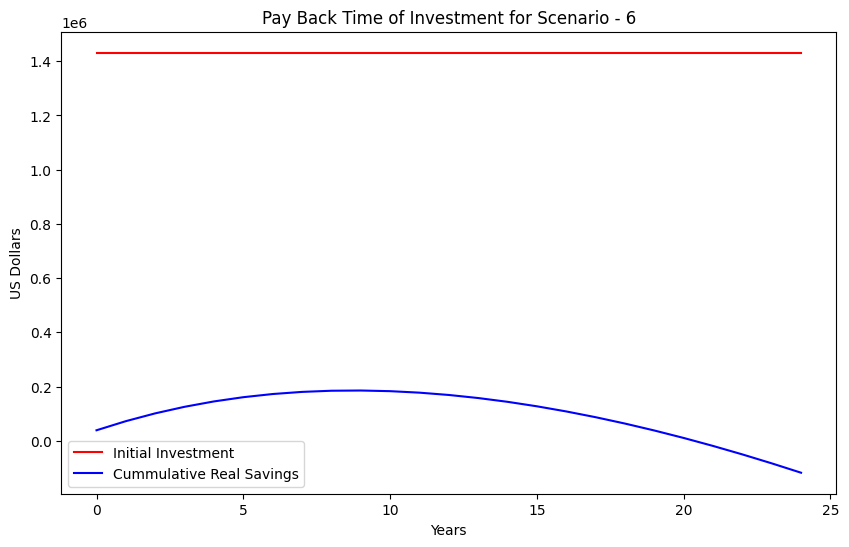

In [76]:
plt.figure(figsize = (10, 6))
plt.plot(Years_Considered, Initial_investment_cost_array_S9, color = 'red', label = 'Initial Investment')
plt.plot(Years_Considered, CumSavings_S9, color = 'blue', label = 'Cummulative Real Savings')
plt.title('Pay Back Time of Investment for Scenario - 6')
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.legend()
plt.show()

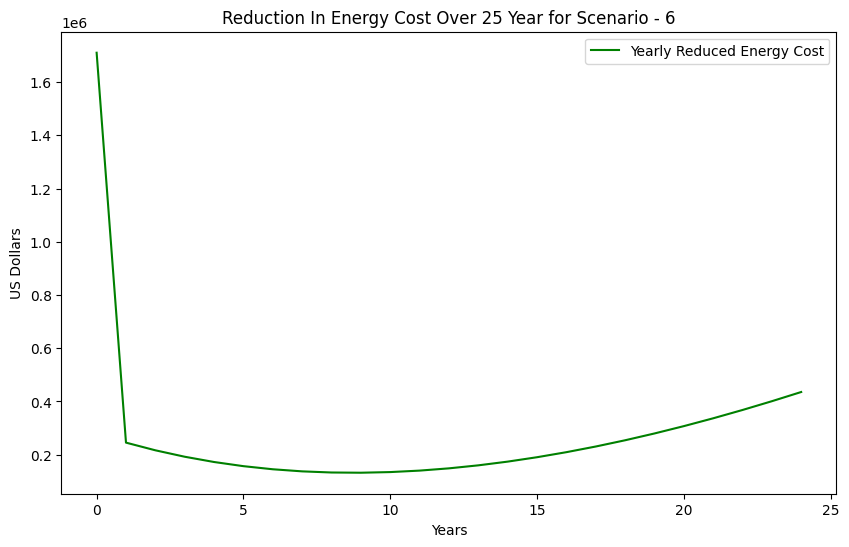

In [77]:
plt.figure(figsize = (10, 6))
plt.plot(Years_Considered, Yearly_Reduced_Energy_Cost_S9, color="green", label="Yearly Reduced Energy Cost")
plt.title('Reduction In Energy Cost Over 25 Year for Scenario - 6')
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.legend()
plt.show()

### Tenth Scenario

In [78]:
New_PV_Power_East_S10 = np.array([inner_dict for inner_dict in results[8]['Hourly_New_PV_Power_East'].values()])
New_PV_Power_SouthEast_S10 = np.array([inner_dict for inner_dict in results[8]['Hourly_New_PV_Power_SouthEast'].values()])
New_PV_Power_South_S10 = np.array([inner_dict for inner_dict in results[8]['Hourly_New_PV_Power_South'].values()])
New_PV_Power_SouthWest_S10 = np.array([inner_dict for inner_dict in results[8]['Hourly_New_PV_Power_SouthWest'].values()])
Existing_PV_Power_S10 = np.array([inner_dict for inner_dict in results[8]['Hourly_Power_Existing_PV'].values()])

Grid_Power_S10 = np.array([inner_dict for inner_dict in results[8]['Hourly_Grid_Power'].values()])
Gen_Power_S10 = np.array([inner_dict for inner_dict in results[8]['Hourly_Gen_Power'].values()])



New_PV_Energy_production_over_25_years_S10 = np.zeros(PV_warranty_period)
Existing_PV_Energy_Production_for_Next_18_years_S10 = np.zeros(PV_warranty_period)

New_PV_Yearly_Savings_S10 = np.zeros(PV_warranty_period)
New_PV_Yearly_Real_Savings_S10 = np.zeros(PV_warranty_period)

Existing_PV_Yearly_Savings_S10 = np.zeros(PV_warranty_period)
Existing_PV_Yearly_Real_Savings_S10 = np.zeros(PV_warranty_period)

New_PV_Power_degradation_S10 = np.zeros(len(New_PV_Power_East_S10))
New_PV_Power_Savings_S10 = np.zeros(len(New_PV_Power_East_S10))

Existing_PV_Power_degradation_S10 = np.zeros(len(New_PV_Power_East_S10))
Existing_PV_Power_Savings_S10 = np.zeros(len(New_PV_Power_East_S10))

Annual_maintenance_cost_S10 = np.array([results[8]['Future_PV_Annual_Maintenance_cost']]*25)

for years in range(PV_warranty_period):
    Existing_PV_Power_factor = 1
    First_year_degradation_rate = 0.025   
    Constant_yearly_degradation_rate = 0.01  
    Inflation_Discount_factor = 0.04
    
    discount_factor = 1/((1 + Inflation_Discount_factor) ** years)
    if years == 1:
        degradation_rate = First_year_degradation_rate
    
    else:
        degradation_rate = Constant_yearly_degradation_rate
        
    for i in range(len(New_PV_Power_East_S9)):
        if Grid_Power_S10[i] > 0 and (New_PV_Power_East_S10[i] > 0 or New_PV_Power_SouthEast_S10[i] > 0 or New_PV_Power_South_S10[i] > 0 or New_PV_Power_SouthWest_S10[i] > 0):
            New_PV_Power_degradation_S10[i] = (value(model.AverageYearly_PowerDemand[i]) - Grid_Power_S10[i] - Existing_PV_Power_S10[i]) * ((1 - degradation_rate)**years)
            New_PV_Power_Savings_S10[i] = New_PV_Power_degradation_S10[i] * CostPerKwh_grid
        
        if Gen_Power_S10[i] > 0 and (New_PV_Power_East_S10[i] > 0 or New_PV_Power_SouthEast_S10[i] > 0 or New_PV_Power_South_S10[i] > 0 or New_PV_Power_SouthWest_S10[i] > 0):
            New_PV_Power_degradation_S10[i] = (value(model.AverageYearly_PowerDemand[i]) - Gen_Power_S10[i] - Existing_PV_Power_S10[i]) * ((1 - degradation_rate)**years)
            New_PV_Power_Savings_S10[i] = New_PV_Power_degradation_S10[i] * CostPerKwh_generators
        
        if Grid_Power_S10[i] > 0 and (Existing_PV_Power_S10[i] > 0):
            degradation_rate = Constant_yearly_degradation_rate
            Existing_PV_Power_degradation_S10[i] = ((value(model.AverageYearly_PowerDemand[i]) - Grid_Power_S10[i] - (New_PV_Power_East_S10[i] + New_PV_Power_SouthEast_S10[i] + New_PV_Power_South_S10[i] + 
                                                    New_PV_Power_SouthWest_S10[i])) * ((1 - degradation_rate)**years))
            Existing_PV_Power_Savings_S10[i] = Existing_PV_Power_degradation_S10[i] * CostPerKwh_grid
        
        if Gen_Power_S10[i] > 0 and (Existing_PV_Power_S10[i] > 0):
            degradation_rate = Constant_yearly_degradation_rate
            Existing_PV_Power_degradation_S10[i] = ((value(model.AverageYearly_PowerDemand[i]) - Gen_Power_S10[i] - (New_PV_Power_East_S10[i] + New_PV_Power_SouthEast_S10[i] + New_PV_Power_South_S10[i] + 
                                                    New_PV_Power_SouthWest_S10[i])) * ((1 - degradation_rate)**years))
            Existing_PV_Power_Savings_S10[i] = Existing_PV_Power_degradation_S10[i] * CostPerKwh_generators

    if years > 17:
        Existing_PV_Power_factor = 0
        
    New_PV_Energy_production_over_25_years_S10[years] = np.sum(New_PV_Power_degradation_S10)
    Existing_PV_Energy_Production_for_Next_18_years_S10[years] = np.sum(Existing_PV_Power_degradation_S10) * Existing_PV_Power_factor
    
    New_PV_Yearly_Savings_S10[years] = np.sum(New_PV_Power_Savings_S10)
    Existing_PV_Yearly_Savings_S10[years] = np.sum(Existing_PV_Power_Savings_S10) * Existing_PV_Power_factor
    
    New_PV_Yearly_Real_Savings_S10[years] = (New_PV_Yearly_Savings_S10[years] * discount_factor) - Annual_maintenance_cost_S10[years]
    Existing_PV_Yearly_Real_Savings_S10[years] = Existing_PV_Yearly_Savings_S10[years] * discount_factor

In [79]:
Minimized_Cost_S10 = results[8]['Minimized Cost ($)']
Yearly_Reduced_Energy_Cost_S10 = np.zeros(PV_warranty_period)
Yearly_Reduced_Energy_Cost_S10[0] = Minimized_Cost_S10
for i in range(1, PV_warranty_period):
    if i == 1:
        Yearly_Reduced_Energy_Cost_S10[i] = (Yearly_Reduced_Energy_Cost_S10[i-1] - (results[8]['New_PV_System_Setup_Cost']) - 
                                           New_PV_Yearly_Real_Savings_S10[i])
    else:
        Yearly_Reduced_Energy_Cost_S10[i] = Yearly_Reduced_Energy_Cost_S10[i-1] - New_PV_Yearly_Real_Savings_S10[i]

In [80]:
Initial_investment_cost_array_S10 = [results[8]['New_PV_System_Setup_Cost']] * 25
CumSavings_S10 = np.cumsum(New_PV_Yearly_Real_Savings_S10)

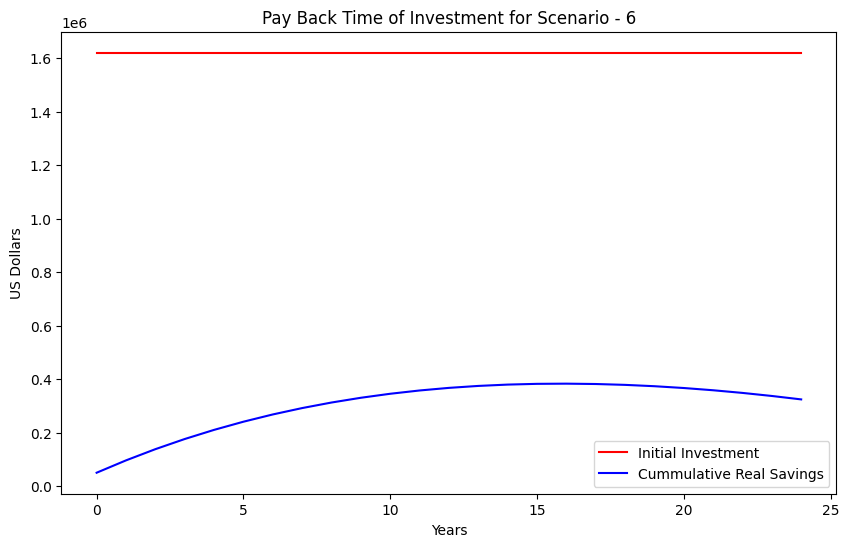

In [81]:
plt.figure(figsize = (10, 6))
plt.plot(Years_Considered, Initial_investment_cost_array_S10, color = 'red', label = 'Initial Investment')
plt.plot(Years_Considered, CumSavings_S6, color = 'blue', label = 'Cummulative Real Savings')
plt.title('Pay Back Time of Investment for Scenario - 6')
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.legend()
plt.show()

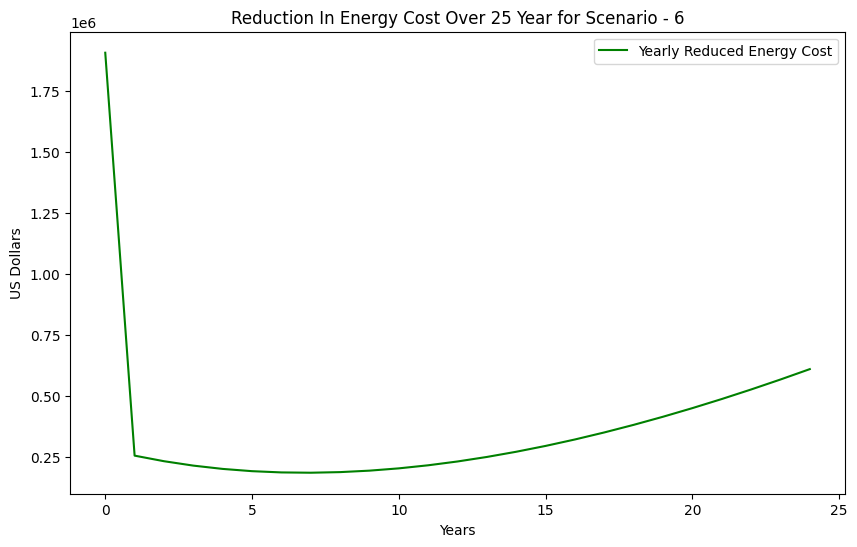

In [82]:
plt.figure(figsize = (10, 6))
plt.plot(Years_Considered, Yearly_Reduced_Energy_Cost_S10, color="green", label="Yearly Reduced Energy Cost")
plt.title('Reduction In Energy Cost Over 25 Year for Scenario - 6')
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.legend()
plt.show()

### PayBack Time  and Net Present Valuation for All Case Scenarios

In [83]:
def conditional_sum_np(Cummulative_savings_array, target):
    index = np.searchsorted(Cummulative_savings_array, target)  # Find the first index where cumsum >= target
    if index < len(Cummulative_savings_array):
        return index, Cummulative_savings_array[index]
    else:
        return index, Cummulative_savings_array[-1]

In [84]:
# Investment_cost_S1 = results[0]['New_PV Capacity (kW)'] * (value(model.costperKW_PV_system + model.costperKW_PV_installation))
# PBT_S1 = conditional_sum_np(CumSavings_S1, Investment_cost_S1)
# NPV_S1 = CumSavings_S1[-1] - Investment_cost_S1

Investment_cost_S2 = results[0]['New_PV_System_Setup_Cost']
PBT_S2 = conditional_sum_np(CumSavings_S2, Investment_cost_S2)
NPV_S2 = CumSavings_S2[-1] - Investment_cost_S2

Investment_cost_S3 = results[1]['New_PV_System_Setup_Cost']
PBT_S3 = conditional_sum_np(CumSavings_S3, Investment_cost_S3)
NPV_S3 = CumSavings_S3[-1] - Investment_cost_S3

Investment_cost_S4 = results[2]['New_PV_System_Setup_Cost']
PBT_S4 = conditional_sum_np(CumSavings_S4, Investment_cost_S4)
NPV_S4 = CumSavings_S4[-1] - Investment_cost_S4

Investment_cost_S5 = results[3]['New_PV_System_Setup_Cost']
PBT_S5 = conditional_sum_np(CumSavings_S5, Investment_cost_S5)
NPV_S5 = CumSavings_S5[-1] - Investment_cost_S5

Investment_cost_S6 = results[4]['New_PV_System_Setup_Cost']
PBT_S6 = conditional_sum_np(CumSavings_S6, Investment_cost_S6)
NPV_S6 = CumSavings_S6[-1] - Investment_cost_S6


Investment_cost_S7 = results[5]['New_PV_System_Setup_Cost']
PBT_S7 = conditional_sum_np(CumSavings_S7, Investment_cost_S7)
NPV_S7 = CumSavings_S7[-1] - Investment_cost_S7


Investment_cost_S8 = results[6]['New_PV_System_Setup_Cost']
PBT_S8 = conditional_sum_np(CumSavings_S8, Investment_cost_S8)
NPV_S8 = CumSavings_S8[-1] - Investment_cost_S8


Investment_cost_S9 = results[7]['New_PV_System_Setup_Cost']
PBT_S9 = conditional_sum_np(CumSavings_S9, Investment_cost_S9)
NPV_S9 = CumSavings_S9[-1] - Investment_cost_S9


Investment_cost_S10 = results[8]['New_PV_System_Setup_Cost']
PBT_S10 = conditional_sum_np(CumSavings_S10, Investment_cost_S10)
NPV_S10 = CumSavings_S10[-1] - Investment_cost_S10


All_cases = ['20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
All_cases_PBT = [PBT_S2[0], PBT_S3[0], PBT_S4[0], PBT_S5[0], PBT_S6[0], PBT_S7[0], PBT_S8[0], PBT_S9[0], PBT_S10[0]]
All_cases_NPV = [NPV_S2, NPV_S3, NPV_S4, NPV_S5, NPV_S6, NPV_S7, NPV_S8, NPV_S9, NPV_S10]

All_investment_cost = [Investment_cost_S2, Investment_cost_S3, Investment_cost_S4, Investment_cost_S5, Investment_cost_S6, Investment_cost_S7, Investment_cost_S8, Investment_cost_S9, Investment_cost_S10]

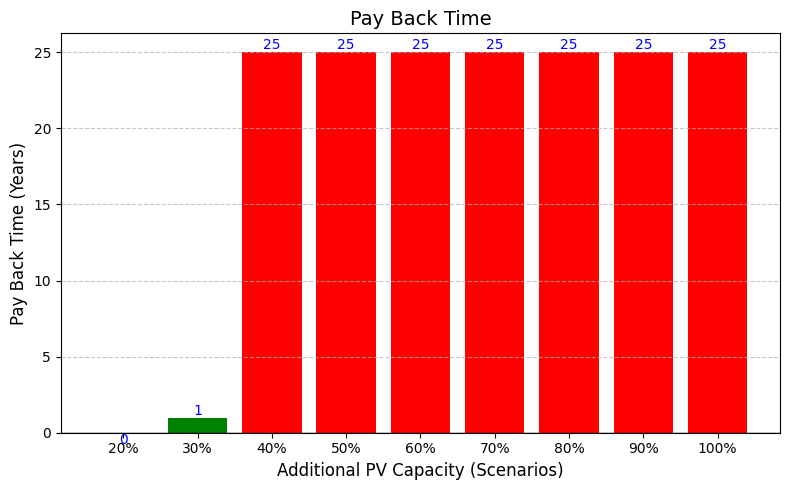

In [85]:
plt.figure(figsize=(8, 5))
bars = plt.bar(All_cases, All_cases_PBT, color=['green' if v < 25 else 'red' for v in All_cases_PBT])


plt.axhline(0, color='black', linewidth=1)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}', 
             ha='center', va='bottom' if yval > 0 else 'top', fontsize=10, color='blue')

plt.title('Pay Back Time', fontsize=14)
plt.xlabel('Additional PV Capacity (Scenarios)', fontsize=12)
plt.ylabel('Pay Back Time (Years)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

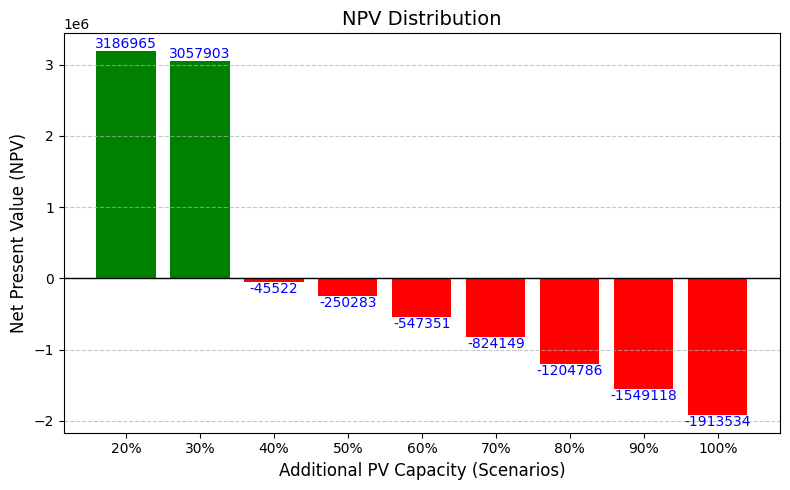

In [86]:
plt.figure(figsize=(8, 5))

bars = plt.bar(All_cases, All_cases_NPV, color=['green' if v >= 0 else 'red' for v in All_cases_NPV])


plt.axhline(0, color='black', linewidth=1)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}', 
             ha='center', va='bottom' if yval > 0 else 'top', fontsize=10, color='blue')


plt.title('NPV Distribution', fontsize=14)
plt.xlabel('Additional PV Capacity (Scenarios)', fontsize=12)
plt.ylabel('Net Present Value (NPV)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### ADDITIONAL PV CAPACITY FOR DIFFERNT LOAD SCENARIOS

In [87]:
#PV_Capacity_S1 = results[0]["New_PV Capacity (kW)"]
PV_Capacity_S2 = results[0]["New_PV Capacity (kW)"]
PV_Capacity_S3 = results[1]["New_PV Capacity (kW)"]
PV_Capacity_S4 = results[2]["New_PV Capacity (kW)"]
PV_Capacity_S5 = results[3]["New_PV Capacity (kW)"]
PV_Capacity_S6 = results[4]["New_PV Capacity (kW)"]
PV_Capacity_S7 = results[5]["New_PV Capacity (kW)"]
PV_Capacity_S8 = results[6]["New_PV Capacity (kW)"]
PV_Capacity_S9 = results[7]["New_PV Capacity (kW)"]
PV_Capacity_S10 = results[8]["New_PV Capacity (kW)"]

Additional_PV_Capacities = [PV_Capacity_S2, PV_Capacity_S3, PV_Capacity_S4, PV_Capacity_S5, PV_Capacity_S6, PV_Capacity_S7, PV_Capacity_S8, PV_Capacity_S9, PV_Capacity_S10]

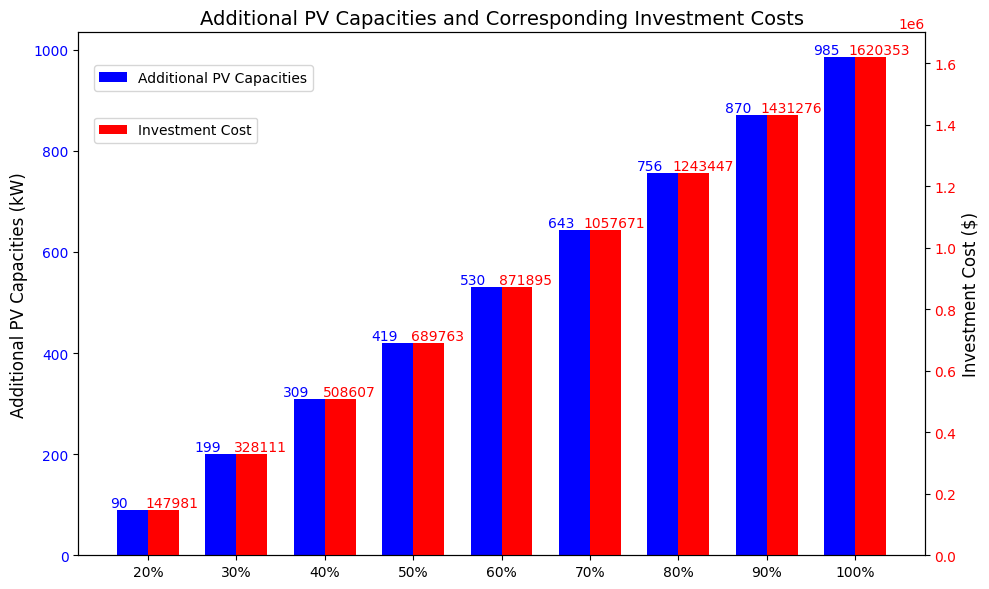

In [88]:
bar_width = 0.35
x = np.arange(len(All_cases))

fig, ax1 = plt.subplots(figsize=(10, 6))

bars_1 = ax1.bar(x - bar_width / 2, Additional_PV_Capacities, color='blue', label='Additional PV Capacities', width=bar_width)
ax1.set_ylabel('Additional PV Capacities (kW)', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')


for bar in bars_1:
    ax1.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height(), f'{bar.get_height():.0f}', 
             ha='center', va='bottom', fontsize=10, color='blue')


ax2 = ax1.twinx()

bars_2 = ax2.bar(x + bar_width / 2, All_investment_cost, color='red', label='Investment Cost', width=bar_width)
ax2.set_ylabel('Investment Cost ($)', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')



for bar in bars_2:
    ax2.text(bar.get_x() + bar.get_width() / 2 + 0.1, bar.get_height(), f'{bar.get_height():.0f}', 
             ha='center', va='bottom', fontsize=10, color='red')


plt.title('Additional PV Capacities and Corresponding Investment Costs', fontsize=14)
plt.xlabel('Scenarios', fontsize=12)
plt.xticks(x, All_cases)

# ax1.legend(['Additional PV Capacities'], loc='upper left', fontsize=10)
# ax2.legend(['Investment Cost'], loc='upper right', fontsize=10)

ax1.legend(['Additional PV Capacities'], loc='upper left', bbox_to_anchor=(0.01, 0.95), fontsize=10)
ax2.legend(['Investment Cost'], loc='upper left', bbox_to_anchor=(0.01, 0.85), fontsize=10)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


## Calculating Internal Rate of Return (IRR)

In [89]:
# IRR_S2 = (npf.irr(np.insert(New_PV_Yearly_Real_Savings_S2, 0, -results[0]['New_PV_System_Setup_Cost']))) * 100
# IRR_S3 = (npf.irr(np.insert(New_PV_Yearly_Real_Savings_S3, 0, -results[1]['New_PV_System_Setup_Cost']))) * 100
# IRR_S4 = (npf.irr(np.insert(New_PV_Yearly_Real_Savings_S4, 0, -results[2]['New_PV_System_Setup_Cost']))) * 100
# IRR_S5 = (npf.irr(np.insert(New_PV_Yearly_Real_Savings_S5, 0, -results[3]['New_PV_System_Setup_Cost']))) * 100
# IRR_S6 = (npf.irr(np.insert(New_PV_Yearly_Real_Savings_S6, 0, -results[4]['New_PV_System_Setup_Cost']))) * 100
# IRR_S7 = (npf.irr(np.insert(New_PV_Yearly_Real_Savings_S7, 0, -results[5]['New_PV_System_Setup_Cost']))) * 100
# IRR_S8 = (npf.irr(np.insert(New_PV_Yearly_Real_Savings_S8, 0, -results[6]['New_PV_System_Setup_Cost']))) * 100
# IRR_S9 = (npf.irr(np.insert(New_PV_Yearly_Real_Savings_S9, 0, -results[7]['New_PV_System_Setup_Cost']))) * 100
# IRR_S10 = (npf.irr(np.insert(New_PV_Yearly_Real_Savings_S10, 0, -results[8]['New_PV_System_Setup_Cost']))) * 100



IRR_S2 = (npf.mirr(np.insert(New_PV_Yearly_Real_Savings_S2, 0, -results[0]['New_PV_System_Setup_Cost']), 0.077, 0.031)) * 100
IRR_S3 = (npf.mirr(np.insert(New_PV_Yearly_Real_Savings_S3, 0, -results[1]['New_PV_System_Setup_Cost']), 0.077, 0.031)) * 100
IRR_S4 = (npf.mirr(np.insert(New_PV_Yearly_Real_Savings_S4, 0, -results[2]['New_PV_System_Setup_Cost']), 0.077, 0.031)) * 100
IRR_S5 = (npf.mirr(np.insert(New_PV_Yearly_Real_Savings_S5, 0, -results[3]['New_PV_System_Setup_Cost']), 0.077, 0.031)) * 100
IRR_S6 = (npf.mirr(np.insert(New_PV_Yearly_Real_Savings_S6, 0, -results[4]['New_PV_System_Setup_Cost']), 0.077, 0.031)) * 100
IRR_S7 = (npf.mirr(np.insert(New_PV_Yearly_Real_Savings_S7, 0, -results[5]['New_PV_System_Setup_Cost']), 0.077, 0.031)) * 100
IRR_S8 = (npf.mirr(np.insert(New_PV_Yearly_Real_Savings_S8, 0, -results[6]['New_PV_System_Setup_Cost']), 0.077, 0.031)) * 100
IRR_S9 = (npf.mirr(np.insert(New_PV_Yearly_Real_Savings_S9, 0, -results[7]['New_PV_System_Setup_Cost']), 0.077, 0.031)) * 100
IRR_S10 = (npf.mirr(np.insert(New_PV_Yearly_Real_Savings_S10, 0, -results[8]['New_PV_System_Setup_Cost']), 0.077, 0.031)) * 100

IRR = [IRR_S2, IRR_S3, IRR_S4, IRR_S5, IRR_S6, IRR_S7, IRR_S8, IRR_S9, IRR_S10]

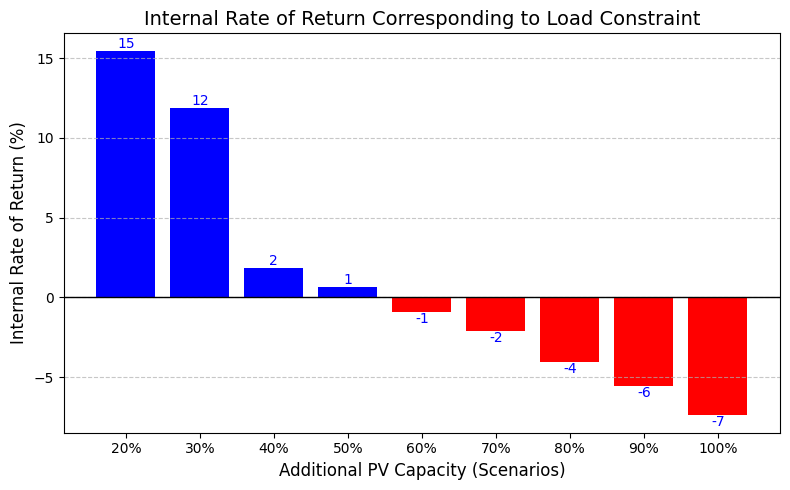

In [90]:
plt.figure(figsize=(8, 5))
bars = plt.bar(All_cases, IRR, color=['blue' if v >= 0 else 'red' for v in IRR])

plt.axhline(0, color='black', linewidth=1)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}', 
             ha='center', va='bottom' if yval > 0 else 'top', fontsize=10, color='blue')

plt.title('Internal Rate of Return Corresponding to Load Constraint', fontsize=14)
plt.xlabel('Additional PV Capacity (Scenarios)', fontsize=12)
plt.ylabel('Internal Rate of Return (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

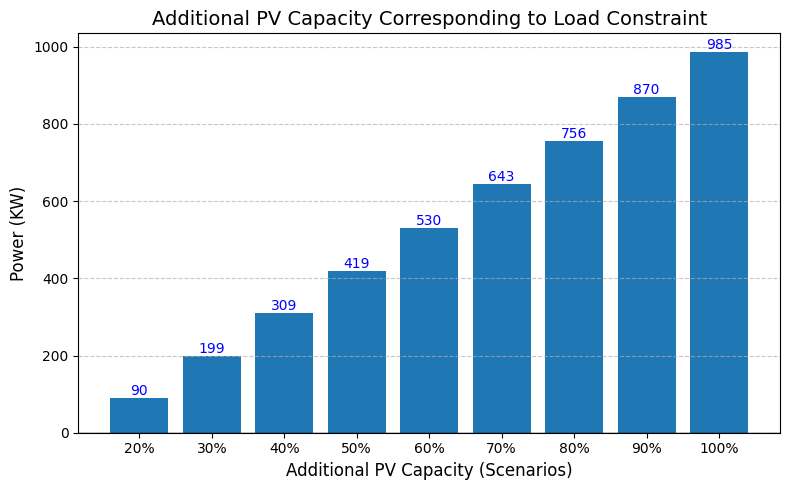

In [91]:
plt.figure(figsize=(8, 5))
bars = plt.bar(All_cases, Additional_PV_Capacities)

plt.axhline(0, color='black', linewidth=1)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}', 
             ha='center', va='bottom' if yval > 0 else 'top', fontsize=10, color='blue')

plt.title('Additional PV Capacity Corresponding to Load Constraint', fontsize=14)
plt.xlabel('Additional PV Capacity (Scenarios)', fontsize=12)
plt.ylabel('Power (KW)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [92]:
AverageDaily_LoadProfile = np.array(Average_Load_Profile['Hourly Power Demand kw'][:24])
LoadTimes = np.array(test_file['Hour'][:24])
string_dates = [dt.strftime('%H:%M') for dt in LoadTimes]
CombinedPV_Production = New_PV_Power_East_S3 + New_PV_Power_SouthEast_S3 + New_PV_Power_South_S3 + New_PV_Power_SouthWest_S3 #+ Exisitng_PV_Power_S1
TypicalDaily_PVproduction = CombinedPV_Production[:24]
TypicalDaily_Grid_Power = Grid_Power_S3[:24]
TypicalDaily_Generator_Power = Gen_Power_S3[:24]
Battery = np.zeros(len(AverageDaily_LoadProfile))

for i in range(5, 17):
    if (TypicalDaily_PVproduction[i] + TypicalDaily_Grid_Power[i] + TypicalDaily_Generator_Power[i]) > AverageDaily_LoadProfile[i]:
        if (TypicalDaily_PVproduction[i] - AverageDaily_LoadProfile[i]) < 0:
            Battery[i] = 0
        else:
            Battery[i] = TypicalDaily_PVproduction[i] - AverageDaily_LoadProfile[i]

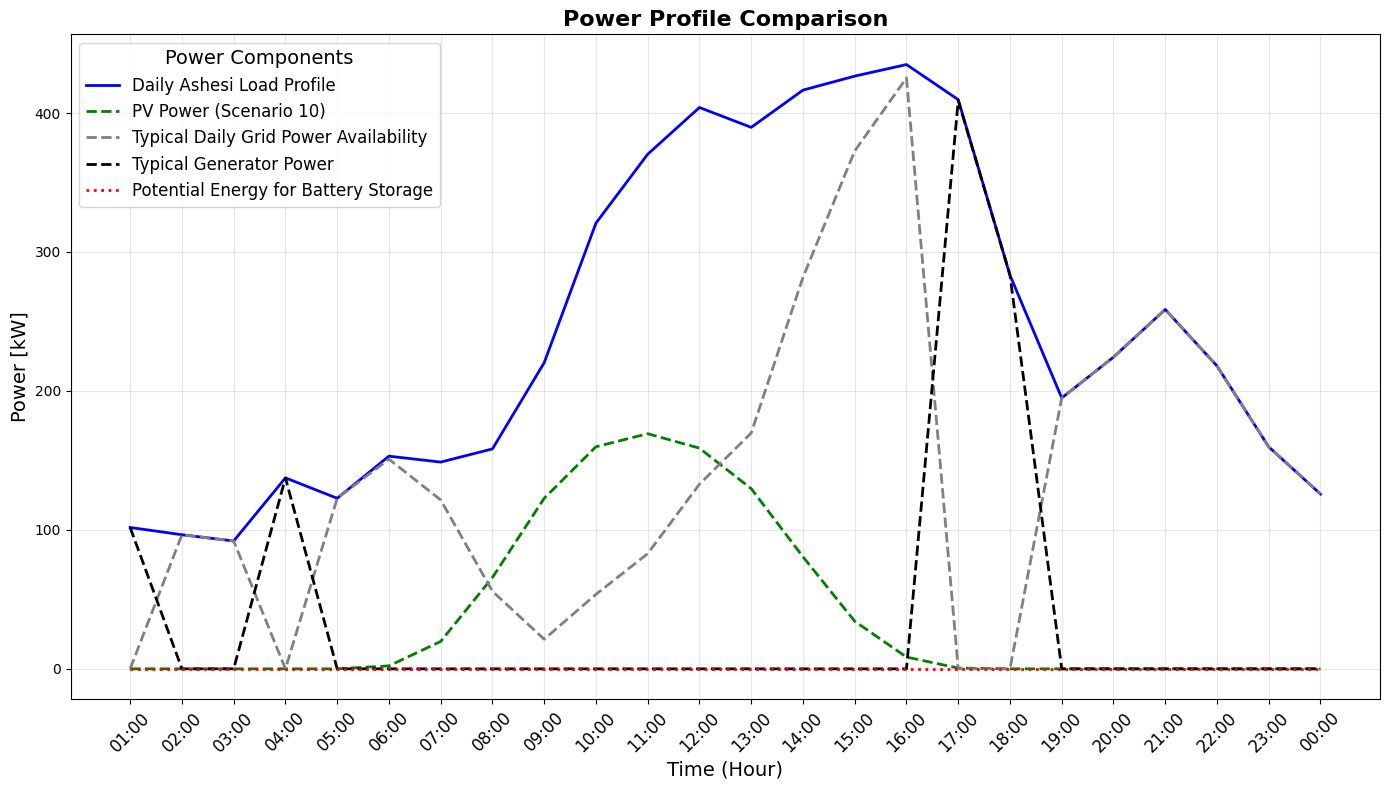

In [93]:
# Create the figure and axis
plt.figure(figsize=(14, 8))

# Plot the data
plt.plot(string_dates, AverageDaily_LoadProfile, color='blue', linewidth=2, linestyle='-', label='Daily Ashesi Load Profile')
plt.plot(string_dates, TypicalDaily_PVproduction, color='green', linewidth=2, linestyle='--', label='PV Power (Scenario 10)')
plt.plot(string_dates, TypicalDaily_Grid_Power, color='grey', linewidth=2, linestyle='--', label='Typical Daily Grid Power Availability')
plt.plot(string_dates, TypicalDaily_Generator_Power, color='black', linewidth=2, linestyle='--', label='Typical Generator Power')
plt.plot(string_dates, Battery, color='red', linewidth=2, linestyle=':', label='Potential Energy for Battery Storage')

# Add title and axis labels with larger fonts
plt.title('Power Profile Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Time (Hour)', fontsize=14)
plt.ylabel('Power [kW]', fontsize=14)

# Rotate x-ticks for better readability
plt.xticks(rotation=45, fontsize=12)

# Add a grid for easier data comparison
plt.grid(alpha=0.3)

# Add a legend with a border and title
plt.legend(title='Power Components', fontsize=12, title_fontsize=14, loc='upper left', frameon=True)

# Adjust layout to avoid clipping labels
plt.tight_layout()

# Display the plot
plt.show()
